## 1. Постановка задачи

**Бизнес задача** — разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

1. Провести разведывательный анализ и очистку исходных данных. 
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные
о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

## 2. Знакомство и расширение данных

In [87]:
import numpy as np
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error
import optuna
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import xgboost as xgb
import time
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

In [88]:
data1 = pd.read_csv("data.csv")

In [89]:
#сделаем копию данных
data = data1.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Описание данных:
* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' - тип объекта недвижимости;
* 'street' - адрес объекта;
* 'baths' - количество ванных комнат;
* 'homeFacts' - сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
* 'fireplace' - наличие камина;
* 'city' - город;
* 'schools' - сведения о школах в районе;
* 'sqft' - площадь в футах;
* 'zipcode' - почтовый индекс;
* 'beds' - количество спален;
* 'state' - штат;
* 'stories' - количество этажей;
* 'mls-id' и 'MlsId' - идентификатор MLS (Multiple Listing Service, система мультилистинга);
* 'target' - цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [90]:
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [91]:
#посчитаем нулевые значения
data.isnull().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

## 3. Обработка и создание новых признаков

В данном разделе кода мы фокусируемся на тщательной предобработке и создании новых признаков из существующего набора данных. Этот процесс включает следующие ключевые шаги:

1. **Очистка и преобразование**: Исходные данные очищаются от дублирующих категорий, ошибок ввода и нестандартных аббревиатур. Для каждого признака проводится специализированная очистка, включая преобразование текстовых данных в числовые, заполнение пропусков и исправление ошибочных значений.

2. **Расшифровка сокращений**: Сокращения и жаргонные выражения в данных идентифицируются и преобразуются в их полные формы для стандартизации и улучшения анализа.

3. **Обработка пропусков**: Пропущенные значения в данных заполняются с помощью различных стратегий, таких как использование медианы или моды, что обеспечивает сохранение статистической целостности набора данных.

4. **Удаление выбросов**: Для повышения точности моделирования из данных удаляются аномальные значения, которые могут исказить результаты обучения.

5. **Создание новых признаков**: На основе существующих данных создаются новые признаки, которые могут улучшить прогностическую способность модели. Это включает в себя выведение количественных характеристик из текстовых описаний, агрегирование и комбинирование различных признаков для создания более комплексных индикаторов.

Каждый из этих шагов способствует повышению качества данных и их пригодности для построения эффективных предиктивных моделей. Такой подход подчеркивает важность тщательного разведывательного анализа данных и их предобработки как критического этапа в аналитическом процессе, непосредственно влияющего на качество и точность последующего моделирования.

### status

In [92]:
patterns = {
    re.compile(r' / auction|.*Auction.*', re.IGNORECASE): 'Auction',
    re.compile(r'C|Option Contract.*', re.IGNORECASE): 'Contract',
    re.compile(r'.*(Conting|Ct|CT|Coming soon|Back on Market).*'): 'Contingent',
    re.compile(r"Pf|Pre-foreclosure.*", re.IGNORECASE): 'Pre Foreclosure',
    re.compile(r"(?i)Foreclos*"): 'Foreclosure',
    re.compile(r'New.*', re.IGNORECASE): 'New',
    re.compile(r'(?i).*pending.*|P|Active Option.'): 'Pending',
    re.compile(r'(?i)For sale.*'): 'for sale',
    re.compile(r'(?i).*Sold.*'): 'Sold',
    re.compile(r'Lease/*|Apartment for rent.*', re.IGNORECASE): 'for rent',
    re.compile(r'(?i).*Backup.*|Accepted|Uc|U\sUnder\sContract|.*Under.*'): 'Under Contract',
    re.compile(r'(?i).*activ.*|Re activated.*'): 'Active'
}

data['status2'] = data['status'].astype(str).apply(
    lambda x: next((replacement for pattern, replacement in patterns.items() if pattern.match(x)), x)
)

# Находим моду признака "status2"
mode_status = data['status2'].mode()[0]

# Заменим пустых значений на моду
data['status2'].fillna(mode_status, inplace=True)
data['status2'] = data['status2'].replace('nan', mode_status)

# Удалим вспомогательные столбцы
data = data.drop(['status'], axis=1)
data['status2'].value_counts().sort_index()

Active                  105712
Auction                   3070
Back On Market               6
Contingent                 194
Contract                  1317
Due Diligence Period        27
Foreclosure               7228
Listing Extended            28
New                       6165
Pending                   7416
Pre Foreclosure           2123
Sold                       289
Under Contract            3715
for rent                   406
for sale                239489
Name: status2, dtype: int64

In [93]:
# как вариант
'''
patterns = {
    re.compile(r'(?i)(for sale|active(?! option contract)|new(?! construction)|coming soon|listing extended|back on market|re activated|active with offer|active backup|active - auction|active option contract|accepting backups|for sale|conditional contract|temporary active|contract)'): 'For Sale Related',
    re.compile(r'(?i)(foreclosure|pre-foreclosure|pre-foreclosure / auction|foreclosed)'): 'Foreclosure Related',
    re.compile(r'(?i)(pending|under contract|option pending|contingent show|pending with contingencies|contract p|pi|pending - taking backups|offer pending signature|pending inspection|pending in|pending w/insp finance|pending ab|backup contract|pending - backup offer requested|pending - continue to show|pending w/ cont.|pending \(do not show\)|pending bring backup|under contract w/ bckp|pending sh|under contract taking back up offers|backup|pending take backups|lease/purchase|pending w/escape clause|pending w/backup wanted|pending backups wanted)'): 'Pending or Under Contract',
    re.compile(r'(?i)(recently sold|sold|lease/\*|apartment for rent|condo for rent|lease/purchase)'): 'Sold or Leased',
    re.compile(r'(?i)(contingent|contingent finance and inspection|contingent - financing|contingent take backup|active contingency|contingent - sale of home|contingent no show|contingent lien holder release|contingent release)'): 'Contingent',
    re.compile(r'(?i)(auction|/ auction|auction - active|a active)'): 'Auction',
    re.compile(r'(?i)(price change|due diligence period|contract contingent on buyer sale|closed|c continue show|p pending sale|reactivated)'): 'Miscellaneous and Special Cases'
}

data['categorized_status'] = data['status'].apply(lambda x: next((category for pattern, category in patterns.items() if pattern.search(str(x))), 'Other'))

data['categorized_status'].value_counts()
'''


"\npatterns = {\n    re.compile(r'(?i)(for sale|active(?! option contract)|new(?! construction)|coming soon|listing extended|back on market|re activated|active with offer|active backup|active - auction|active option contract|accepting backups|for sale|conditional contract|temporary active|contract)'): 'For Sale Related',\n    re.compile(r'(?i)(foreclosure|pre-foreclosure|pre-foreclosure / auction|foreclosed)'): 'Foreclosure Related',\n    re.compile(r'(?i)(pending|under contract|option pending|contingent show|pending with contingencies|contract p|pi|pending - taking backups|offer pending signature|pending inspection|pending in|pending w/insp finance|pending ab|backup contract|pending - backup offer requested|pending - continue to show|pending w/ cont.|pending \\(do not show\\)|pending bring backup|under contract w/ bckp|pending sh|under contract taking back up offers|backup|pending take backups|lease/purchase|pending w/escape clause|pending w/backup wanted|pending backups wanted)'): 'P

### Street

In [94]:
# Заменим пустые значения на моду признака
data['street'].fillna(data['street'].mode()[0], inplace=True)

### propertyType

In [95]:
data['propertyType'].value_counts()

single-family home                                             92206
Single Family                                                  62869
Single Family Home                                             31728
condo                                                          25968
lot/land                                                       20552
                                                               ...  
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
1 Story, Contemporary, Traditional, Mediterranean                  1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1280, dtype: int64

Этот код упрощает и категоризирует данные о типах недвижимости в столбце 'propertyType', используя регулярные выражения для группировки разнообразных описаний в три основные категории: 'multi-family', 'Manufactured housing', и 'one-to-four'. Затем создается новый столбец 'propertyType_New', который содержит эти упрощенные категории. Исходный столбец 'propertyType' удаляется для устранения дублирования и упрощения структуры данных.

In [96]:
# Паттерны для оптимизации
patterns = {
    r"(?i)\b(multi|condo|Condominium|Townhome|row home|co-op|coop|apartment|High Rise|Flat)\b": "multi-family",
    r"(?i)\b(Duplex|Triplex|Townhouse|townhouse|Cooperative|Penthouse|Bungalow|Multiple)\b": "multi-family",
    r"(?i)\b(Manufactured|Mfd|Mobile)\b": "Manufactured housing",
    r"(?i)\b(Single|story|Stories|transitional|Land|Ranch|Ranches|Contemporary|Colonial|Residential|Traditional|Garden Home|Cape Cod|Spanish|Mediterranean|Cluster Home|Florida|Tudor|SingleFamilyResidence|Craftsman|Cottage)\b": "one-to-four"
}

# Оптимизация столбца 'propertyType' с помощью паттернов
data['propertyType'] = data['propertyType'].replace(patterns, regex=True)

# Выведем совпадающие значения из списка в новый признак
keywords = ["multi-family", "Manufactured housing", "one-to-four"]
data['propertyType_New'] = data['propertyType'].apply(
    lambda x: next((keyword for keyword in keywords
                    if re.search(keyword, str(x), re.IGNORECASE)), 'one-to-four')).fillna('')
                    
# Удалим вспомогательные столбцы
data = data.drop(['propertyType'], axis=1)


In [97]:
data['propertyType_New'].value_counts()

one-to-four             283434
multi-family             90170
Manufactured housing      3581
Name: propertyType_New, dtype: int64

### bath

In [98]:
# Извлечение только целых чисел из признака 'baths'
data['baths'] = data['baths'].str.extract(r'(\d+)').astype(float)
# Заменим все пустые значения на 0
data['baths'].fillna(0, inplace=True)
# Заменим тип данных на числовой
data['baths'] = data['baths'].astype(int)

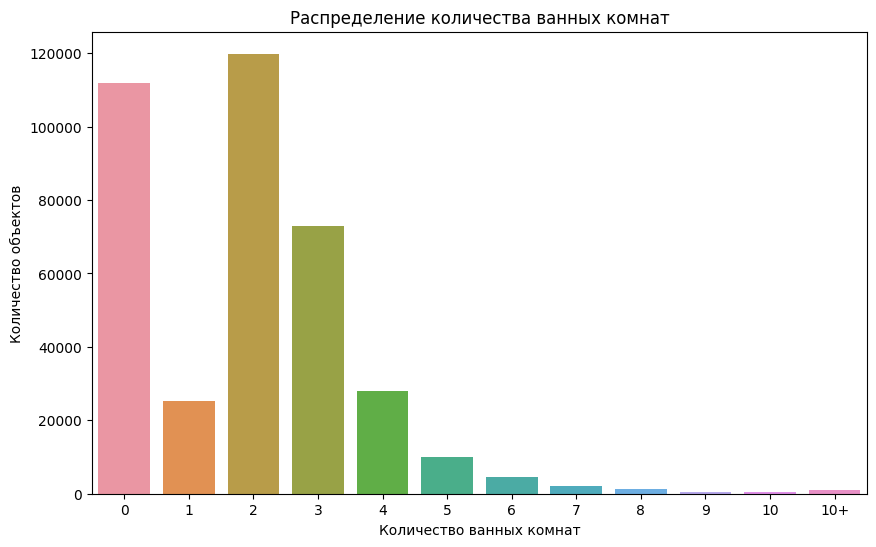

In [99]:
# Создаем категории для значений больше 10
baths_grouped = data['baths'].apply(lambda x: '10+' if x > 10 else str(x))

# Укажим желаемый порядок категорий
desired_order = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10+']

# Подсчитаем количество объектов в каждой категории и отсортируйте их
baths_counts = baths_grouped.value_counts().loc[desired_order]

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=baths_counts.index, y=baths_counts.values)
plt.title('Распределение количества ванных комнат')
plt.xlabel('Количество ванных комнат')
plt.ylabel('Количество объектов')
plt.show()


### city

Для каждого штата (state) мы находим наиболее часто встречающийся город (city) в нашем наборе данных. Это делается с помощью группировки по state и применения агрегирующей функции pd.Series.mode к city.
Полученная серия state_mode преобразуется в DataFrame для удобства дальнейшего использования. Затем столбцам присваиваются названия ['state', 'mode_city'].
Затем добавляем новый столбец mode_city в основной DataFrame data, объединяя его с state_mode по ключу state.
Мы заменяем пропущенные значения (NaN), пустые строки и строки с "--" в столбце city на соответствующие значения из mode_city.
После замены вы удалим столбец mode_city из основного DataFrame data.

После построим карту с визуализацией количества недвижимости по штатам.

In [100]:
# Вывод значений моды city для каждого state
state_mode = data.groupby(['state'])['city'].agg(pd.Series.mode)

# Преобразование серии в датафрейм
state_mode = state_mode.reset_index()
state_mode.columns = ['state', 'mode_city']

# Объединение по ключу 'state' и добавление нового признака 'mode_city'
data = pd.merge(data, state_mode, on='state', how='left')

# Заменим лишние и пустые значения на моду по штату
data.loc[(data['city'].isna()) | (data['city'] == " ")
| (data['city'] == "--"), 'city'] = data['mode_city']

# Удалим вспомогательные столбцы
data = data.drop(['mode_city'], axis=1)

In [101]:
import plotly.express as px
import us

# Преобразование аббревиатур в полные названия
data['state_full'] = data['state'].apply(lambda x: us.states.lookup(x).name if us.states.lookup(x) else x)

# После этого мы можем использовать 'state_full' для сопоставления с геоданными
# Генерация количества объектов недвижимости по штатам
state_counts = data['state'].value_counts().reset_index()
state_counts.columns = ['state', 'property_count']

# Визуализация данных на карте США
fig = px.choropleth(
    state_counts,
    locations='state',  # Это поле сокращений штатов в нашем DataFrame
    locationmode='USA-states',  # Режим отображения использует сокращения штатов США
    color='property_count',  # Поле с данными для отображения
    scope="usa",  # Ограничиваем карту только США
    title='Количество объектов недвижимости по штатам'
)

fig.show()


### homeFacts

В этом коде происходит десериализация и расширенная обработка данных из столбца 'homeFacts' недвижимости:

1. **Десериализация данных**: Содержимое столбца 'homeFacts' преобразуется из строкового формата JSON в словари Python с помощью функции `ast.literal_eval`.

2. **Извлечение и создание новых признаков**: Для каждой записи извлекаются и создаются новые столбцы на основе ключевых значений в десериализованных данных, таких как 'YearBuilt', 'RemodeledYear', 'Heating', 'Cooling', 'Parking', 'LotSize' и 'PricePerSqft'. Это обеспечивает более детальное и структурированное представление данных о недвижимости.

3. **Удаление старого столбца 'homeFacts'**: После извлечения всех необходимых данных, исходный столбец 'homeFacts' удаляется из DataFrame для упрощения и улучшения читаемости данных.

Эти шаги значительно повышают качество и информативность данных, предоставляя более подробную информацию о каждом объекте недвижимости для последующего анализа и моделирования.

In [102]:
# Десериализуем содержимое признака 'homeFacts'
data['homeFacts'] = data['homeFacts'].apply(ast.literal_eval)

# Извлекаем значения по ключу 'factLabel'
fact_labels = [item['factLabel'] for item in data['homeFacts'][0]['atAGlanceFacts']]
# Выводим заголовки списком
print(fact_labels)

['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']


In [103]:
# Создадим новые признаки на основе десериализованных значений
data['YearBuilt'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
data['RemodeledYear'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
data['Heating'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
data['Cooling'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
data['Parking'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
data['LotSize'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
data['PricePerSqft'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

# Удалим старый столбец
data = data.drop(['homeFacts'], axis=1)

### homeFacts очистка

Этот код включает серию шагов по очистке и стандартизации данных в нескольких столбцах недвижимости:

1. **YearBuilt**: Очищает столбец 'YearBuilt' от неверных или нестандартных значений (например, пустых строк, 'No Data'), заменяя их на `None`, что приведет к преобразованию их в `NaN` в Pandas.

2. **RemodeledYear**: Преобразует все нулевые значения в столбце 'RemodeledYear' в `NaN`, тем самым удаляя некорректные или отсутствующие данные о годе ремонта.

3. **Heating, Cooling, Parking**: Стандартизирует категориальные признаки 'Heating', 'Cooling' и 'Parking', заменяя определенный набор строковых значений на 0 и все остальные на 1, что превращает их в бинарные признаки (0 или 1). Пустые значения также заменяются на 0.

4. **LotSize, PricePerSqft**: Извлекает числовые значения из строковых столбцов 'LotSize' и 'PricePerSqft', преобразуя их в числовые форматы и удаляя нечисловые символы. Это обеспечивает консистентность данных для анализа площади участка и цены за квадратный фут.

Эти шаги улучшают качество данных, делая их более подходящими для анализа и моделирования.

In [104]:
# Создадим список значений для поиска
values_to_replace = ['', '559990649990', 'No', '1', 'No Data']
# Заменим значения из списка
data['YearBuilt'] = np.where(data['YearBuilt'].isin(values_to_replace), None, data['YearBuilt'])

# заменим 0 значения на NaN
data['RemodeledYear'] = np.where(data['RemodeledYear'] == 0, np.nan, data['RemodeledYear']).astype('object')

In [105]:
# Создадим список значений для поиска
values_to_replace = ['', 'No Data', 'None']
# Заменим значения из списка на 0, а остальные на 1
data['Heating'] = data['Heating'].replace(values_to_replace, 0).replace('[^0]', 1, regex=True)
data['Cooling'] = data['Cooling'].replace(values_to_replace, 0).replace('[^0]', 1, regex=True)
data['Parking'] = data['Parking'].replace(values_to_replace, 0).replace('[^0]', 1, regex=True)

# Заменим пустые значения на 0
data['Heating'] = data['Heating'].fillna(0).astype(int)
data['Cooling'] = data['Cooling'].fillna(0).astype(int)
data['Parking'] = data['Parking'].fillna(0).astype(int)
data['Parking'] = data['Parking'].replace('0', 0).astype(int)

In [106]:
# извлечем из признаков только числа
data['LotSize'] = data['LotSize'].str.extract('(\d+.\d+|\d+)', expand=False)
data['PricePerSqft'] = data['PricePerSqft'].str.extract('(\d+.\d+|\d+)', expand=False)

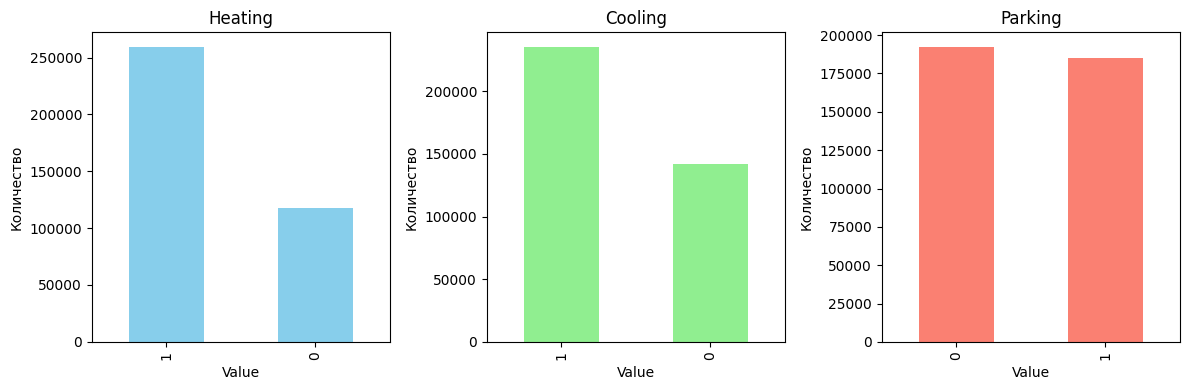

In [107]:
# Создаем график для признака Heating
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
data['Heating'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Heating')
plt.xlabel('Value')
plt.ylabel('Количество')

# Создаем график для признака Cooling
plt.subplot(1, 3, 2)
data['Cooling'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Cooling')
plt.xlabel('Value')
plt.ylabel('Количество')

# Создаем график для признака Parking
plt.subplot(1, 3, 3)
data['Parking'].value_counts().plot(kind='bar', color='salmon')
plt.title('Parking')
plt.xlabel('Value')
plt.ylabel('Количество')

# Отображаем графики
plt.tight_layout()
plt.show()


На представленных графиках показано распределение наличия и отсутствия трех основных удобств в объектах недвижимости: системы отопления (Heating), системы охлаждения (Cooling) и наличие парковочных мест (Parking). Значение "1" указывает на присутствие соответствующего удобства, тогда как "0" обозначает его отсутствие.

1. **Отопление (Heating)**: Большинство объектов оборудовано системой отопления, что видно из значительно большего количества столбцов со значением "1" по сравнению с теми, где отопление отсутствует.

2. **Охлаждение (Cooling)**: Столбец с значением "1" намного меньше по сравнению с отоплением, что может указывать на меньшую распространенность систем охлаждения в выборке недвижимости.

3. **Парковка (Parking)**: Распределение мест для парковки показывает примерно равное количество объектов с наличием и отсутствием парковки, что отражает столбцы с значениями "1" и "0" примерно одинаковой высоты.

Эти графики помогают наглядно оценить, какие удобства чаще встречаются в предложениях о недвижимости, что может быть важным фактором при принятии решений потенциальными покупателями или инвесторами.

### schools

Обрабатываем данные, связанные со школами, которые содержатся в признаке 'schools' нашего датафрейма. Десериализуем информацию о школах, создадим новые признаки, такие как рейтинг школы, расстояние до неё и количество школ, затем рассчитываем средние и минимальные расстояния до школ и средний рейтинг, и удалим вспомогательные признаки после использования.

In [108]:
# Десериализуем содержимое признака 'homeFacts'
data['schools'] = data['schools'].apply(ast.literal_eval)

# Создадим новые признаки из признака 'schools' и применить функцию lambda
data['rating'] = data['schools'].apply(lambda x: x[0]['rating'])
data['Distance'] = data['schools'].apply(lambda x: x[0]['data']['Distance'])
data['name_school'] = data['schools'].apply(lambda x: x[0]['name'])

# Создадим признак с количеством школ
data['school_count'] = data['name_school'].apply(len)
# Выислим сумму расстояний до школ
data['sum_distance'] = data['Distance'].apply(lambda x: sum(float(re.findall(
    r'\d+\.\d+', val)[0]) for val in x if re.findall(r'\d+\.\d+', val)) if x and
                                              any(re.findall(r'\d+\.\d+', val) for val in x) else None)
# Посчитаем среднюю дистанцию до школы
data['Avr_distance'] = data['sum_distance'] / data['school_count']

In [109]:
# Извлечение цифр и вычисление среднего расстояния до школы
data['MinDistance'] = data['Distance'].apply(
    lambda x: min(float(re.findall(r'\d+\.\d+', val)[0]) for val in x if re.
                  findall(r'\d+\.\d+', val)) if x and any(re.findall(r'\d+\.\d+',
                                                                     val) for val in x)
                  else None
)

# Функция для обработки и вычисления значения рейтинга
def calculate_rating(row):
    ratings = []
    for val in row:
        if re.match(r'^[\d./]+$', val):
            val = re.sub(r'/10$', '', val)
            try:
                ratings.append(float(val))
            except ValueError:
                pass
    return np.mean(ratings) if ratings else np.nan
    ratings

# Применение функции calculate_rating к столбцу 'rating' и создание нового столбца 'AverageRating'
data['AverageRating'] = data['rating'].apply(calculate_rating)

# Удалим вспомогательные столбцы
data = data.drop(['sum_distance', 'schools', 'rating', 'Distance', 'name_school'], axis=1)

Построим графики для рейтинга

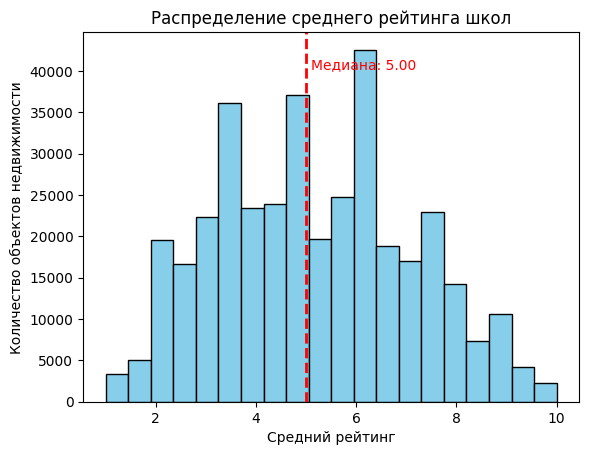

In [110]:
# Гистограмма распределения среднего рейтинга школ
plt.hist(data['AverageRating'].dropna(), bins=20, color='skyblue', edgecolor='black')

# Вычисление медианного значения среднего рейтинга
median_rating = data['AverageRating'].median()

# Добавление пунктирной линии для медианного значения
plt.axvline(median_rating, color='red', linestyle='dashed', linewidth=2)

# Добавление текста с медианным значением
plt.text(median_rating + 0.1, plt.ylim()[1]*0.9, f'Медиана: {median_rating:.2f}', color='red')

plt.title('Распределение среднего рейтинга школ')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество объектов недвижимости')
plt.show()

График иллюстрирует распределение среднего рейтинга школ, связанных с объектами недвижимости, с использованием гистограммы. Гистограмма показывает, как часто встречаются школы с различными средними рейтингами. Большая часть объектов недвижимости связана со школами, средний рейтинг которых находится около показателя 5, что указывает на умеренный уровень образовательных учреждений в этих районах. Медианное значение, отмеченное пунктирной линией, указывает на то, что половина всех рассматриваемых школ имеет рейтинг выше 5, а другая половина — ниже. Это позволяет сделать вывод о том, что распределение рейтинга школ среди объектов недвижимости склоняется к среднему уровню качества образования.

In [111]:
# Группировка данных по штатам и расчет среднего рейтинга школ для каждого штата
state_avg_rating = data.groupby('state')['AverageRating'].mean().reset_index()

# Визуализация данных на карте США с использованием Plotly
fig = px.choropleth(
    state_avg_rating,  # Используем подготовленный DataFrame
    locations='state',  # Используем полные названия штатов для сопоставления
    locationmode='USA-states',  # Указываем, что locations основаны на названиях штатов США
    color='AverageRating',  # Значение, которое будет использоваться для раскраски штатов
    color_continuous_scale='Viridis',  # Шкала цветов для раскраски
    scope='usa',  # Ограничение карты США
    title='Средний рейтинг школ по штатам',  # Заголовок карты
    labels={'AverageRating': 'Средний рейтинг школ'}  # Подпись для легенды
)

# Отображение карты
fig.show()


На представленной карте США отображается средний рейтинг школ по штатам. Карта показывает, что не для всех штатов доступна информация о рейтинге школ, что видно по отсутствию окраски в некоторых из них. Там, где данные доступны, штаты раскрашены в различные оттенки, соответствующие среднему рейтингу школ, согласно шкале справа. Например, штат Монтана имеет более светлый оттенок, что указывает на более высокий средний рейтинг школ по сравнению с темной окраской Пенсильвании, что свидетельствует о более низком среднем рейтинге школ в этом штате.

### sqft

In [112]:
# Выведем только числа из признака 'sqft'
data['sqft'] = data['sqft'].apply(lambda x: re.sub(r'\D', '', str(x)))
data['sqft'] = data['sqft'].replace('', np.nan)
data['sqft'] = data['sqft'].dropna().astype(int)

# Замена пустых значений в столбце 'sqft' на медианное значение этого столбца
data['sqft'].fillna(data['sqft'].median(), inplace=True)

data['sqft'].head()

0    2900.0
1    1947.0
2    3000.0
3    6457.0
4    1800.0
Name: sqft, dtype: float64

### zipcode

In [113]:
data['zipcode'].mode()[0]

'32137'

В коде для столбца 'zipcode' сначала извлекаются числовые значения из строковых индексов, затем '0' и '00000' заменяются на NaN, а пропущенные значения заполняются модой. После этого данные преобразуются в целочисленный формат для упрощения анализа и избегания ошибок в данных, связанных с почтовыми индексами.

In [114]:
# Функция для извлечения числового значения из строки индекса
def extract_zipcode_number(zipcode):
    match = re.match(r'^(\d+)-?', str(zipcode))  # Ищем последовательность цифр от начала строки до символа разделения '-'
    return match.group(1) if match else np.nan  # Возвращаем найденное значение или NaN

# Применение функции к столбцу
data['zipcode'] = data['zipcode'].apply(extract_zipcode_number)

# Замена значений '0' и '00000' на NaN
data['zipcode'].replace({'0': np.nan, '00000': np.nan}, inplace=True)

# Заполнение пропущенных значений модой
data['zipcode'].fillna(data['zipcode'].mode()[0], inplace=True)

# Преобразование столбца в int64
data['zipcode'] = data['zipcode'].astype('int64')

# Подсчет пропущенных значений
missing_values = data['zipcode'].isnull().sum()
print("Количество пропусков в столбце 'zipcode':", missing_values)

Количество пропусков в столбце 'zipcode': 0


### target

В коде производится очистка и преобразование целевого признака 'target' путем удаления нечисловых символов и конвертации значений в числовой формат. Затем реализуется функция outliers_iqr для определения и фильтрации выбросов по методу межквартильного размаха (IQR), позволяя исключить аномальные значения. В конце применяется фильтрация данных для удаления значений целевого признака ниже установленного порога и проводится повторный анализ выбросов с обновленной функцией detect_outliers_IQR.

In [115]:
data['target'] = data['target'].apply(lambda x: re.sub(r'\D', '', str(x)))
data['target'] = data['target'].replace('', np.nan)
data['target'] = data['target'].dropna().astype(float)

In [116]:
# уберем значения менее 100 по признаку
data = data[data['target'] > 110]

# Обновленная функция для определения выбросов при помощи IQR
def detect_outliers_IQR(data, feature, threshold=1.5):
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)
    outliers = (data[feature] < lower_bound) | (data[feature] > upper_bound)
    
    # Чистые данные (не выбросы)
    clean_data = data[~outliers]  # отбираем данные, которые не являются выбросами
    
    print("Число выбросов:", outliers.sum())
    print("Число чистых данных:", clean_data.shape[0])
    
    return outliers, clean_data

# Применим функцию к целевому признаку 'target' в вашем датафрейме 'data'
outliers, clean_data = detect_outliers_IQR(data, 'target')

# Выведем первые несколько строк чистых данных для оценки
print(clean_data.head())
data = clean_data.copy()

Число выбросов: 38176
Число чистых данных: 336506
  private pool             street  baths fireplace            city    sqft  \
0          NaN     240 Heather Ln      3  Gas Logs  Southern Pines  2900.0   
1          NaN  12911 E Heroy Ave      3       NaN  Spokane Valley  1947.0   
4          NaN     1524 Kiscoe St      0       NaN        Palm Bay  1800.0   
5          NaN  1624 S Newkirk St      0       NaN    Philadelphia   897.0   
6          NaN   552 Casanova Ct       0       NaN       POINCIANA  1507.0   

   zipcode    beds state stories  ... RemodeledYear Heating Cooling  Parking  \
0    28387       4    NC     NaN  ...                     1       0        0   
1    99216  3 Beds    WA     2.0  ...                     0       0        0   
4    32908     NaN    FL     NaN  ...                     0       0        0   
5    19145  2 Beds    PA     2.0  ...                     1       1        0   
6    34759     NaN    FL     One  ...          2006       1       1        0   



In [117]:
import plotly.express as px
import us

# Генерация средней цены недвижимости по штатам
state_avg_price = data.groupby('state')['target'].mean().reset_index()
state_avg_price.columns = ['state', 'average_price']

# Визуализация данных на карте США
fig = px.choropleth(
    state_avg_price,
    locations='state',  # Это поле с названиями штатов в нашем DataFrame
    locationmode='USA-states',  # Режим отображения использует сокращения штатов США
    color='average_price',  # Поле с данными для отображения
    color_continuous_scale='Viridis',  # Градиент цвета для значения
    scope="usa",  # Ограничиваем карту только США
    title='Средняя цена недвижимости по штатам',
    labels={'average_price': 'Средняя цена'}  # Подпись для легенды
)

# Показать фигуру
fig.show()


Основываясь на предоставленных данных, карта средней цены недвижимости по штатам показала значительные различия в стоимости недвижимости по всей территории США. Наиболее высокие средние цены наблюдаются в столичном округе Колумбия (DC), Калифорнии (CA), Массачусетсе (MA), Нью-Йорке (NY), и Орегоне (OR). Это указывает на высокий спрос и дороговизну жизни в этих регионах, часто связанную с экономическим благополучием, доступностью рабочих мест и другими социально-экономическими факторами.

В то же время штаты как Оклахома (OK), Алабама (AL) и другие с неясными аббревиатурами (OS, OT), показывают значительно более низкие средние цены. Это может отражать меньшую плотность населения, меньший спрос на недвижимость или более доступный уровень жизни.

In [118]:
data['target'].head()

0    418000.0
1    310000.0
4      5000.0
5    209000.0
6    181500.0
Name: target, dtype: float64

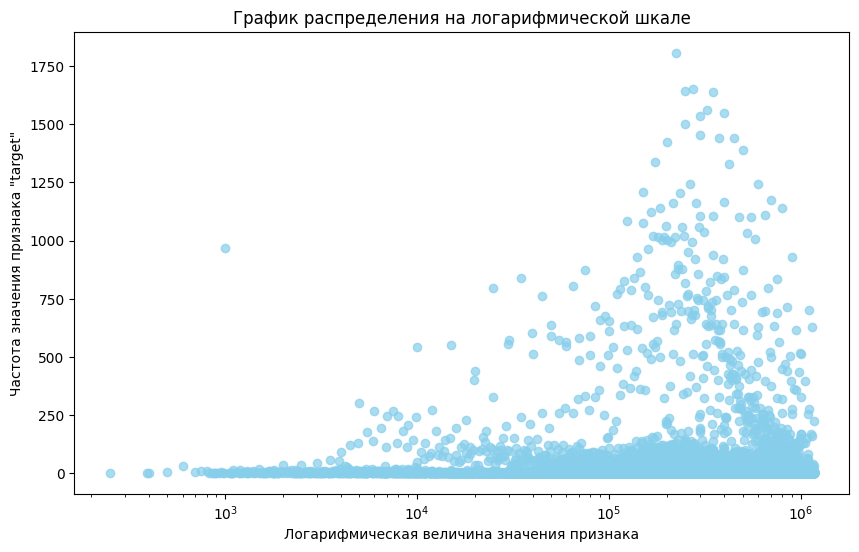

In [119]:
target_counts = data.groupby('target')['target'].agg('count')

# Построение графика распределения на логарифмической шкале
plt.figure(figsize=(10, 6))
plt.scatter(target_counts.index, target_counts, color='skyblue', alpha=0.7)
plt.xscale('log')  # Настройка масштаба оси x на логарифмический
plt.title('График распределения на логарифмической шкале')
plt.xlabel('Логарифмическая величина значения признака')
plt.ylabel('Частота значения признака "target"')
plt.show()

In [120]:
from scipy.stats import normaltest
# тест Д’Агостино на нормальность распределения
stat, p = normaltest(data["target"])
alpha = 0.05
if p < alpha:
    print("Нулевая гипотеза отвергается, распределение не является нормальным")
else:
    print("Нулевая гипотеза не отвергается, распределение может быть нормальным")
    
#Чему равен вычисленный p-value?
print("p-value =", p)

Нулевая гипотеза отвергается, распределение не является нормальным
p-value = 0.0


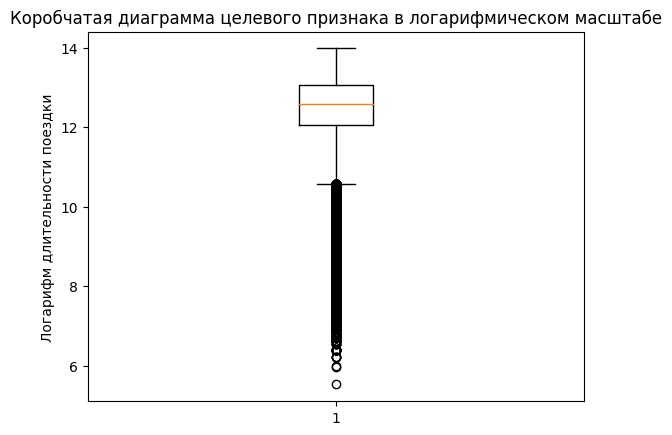

In [121]:
# логарифмируем признак
target_log = np.log(data['target']+1)

# построение коробчатой диаграммы
plt.boxplot(target_log)
plt.title("Коробчатая диаграмма целевого признака в логарифмическом масштабе")
plt.ylabel("Логарифм длительности поездки")
plt.show()

In [122]:
from scipy import stats

# Критерий Шапиро-Уилка
shapiro_test_stat, shapiro_p_value = stats.shapiro(data['target'])
print(f"Критерий Шапиро-Уилка: статистика={shapiro_test_stat}, p-значение={shapiro_p_value}")

# Критерий Колмогорова-Смирнова
ks_test_stat, ks_p_value = stats.kstest(data['target'], cdf='norm')
print(f"Критерий Колмогорова-Смирнова: статистика={ks_test_stat}, p-значение={ks_p_value}")


Критерий Шапиро-Уилка: статистика=0.9225509166717529, p-значение=0.0
Критерий Колмогорова-Смирнова: статистика=1.0, p-значение=0.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



### beds

In [123]:
data['beds'].head()

0         4
1    3 Beds
4       NaN
5    2 Beds
6       NaN
Name: beds, dtype: object

В этом коде осуществляется очистка и преобразование данных в столбце 'beds', который содержит информацию о количестве спален, включая мусорные значения. Сначала создается временный бинарный признак 'temp', где '1' указывает на наличие мусорных значений (таких как 'acre', 'acres', 'sqft'), а '0' — на корректные данные. Далее формируется новый признак 'beds_new', в который извлекаются только числовые значения из 'beds', если они соответствуют условию 'temp'. После этого исходный столбец 'beds' и вспомогательный 'temp' удаляются. В 'beds_new' пропущенные значения заполняются медианой, а столбец преобразуется в числовой формат для дальнейшего анализа.

In [124]:

# Создаем временный бинарный признак 'temp', где '1' - содержит мусорные значения, '0' -правильные
data['temp'] = data['beds'].astype(str).str.contains(r'acre|acres|sqft', case=False, regex=True).astype(int)

# Создаем новый признак 'beds_new', в который извлекаем только числовые значения из 'beds'
data['beds_new'] = data['beds'].str.extract(r'(\d+)')[0]

# Удаляем исходный столбец 'beds' и временный столбец 'temp'
data.drop(['beds', 'temp'], axis=1, inplace=True)

# Преобразуем 'beds_new' в числовой тип и заполняем пропущенные значения медианой
data['beds_new'] = pd.to_numeric(data['beds_new'], errors='coerce')
data['beds_new'].fillna(data['beds_new'].median(), inplace=True)

# Теперь 'data' содержит столбец 'beds_new' с числовыми значениями, готовыми для анализа
data['beds_new']


0         4.0
1         3.0
4         3.0
5         2.0
6         3.0
         ... 
377179    2.0
377181    3.0
377182    3.0
377183    8.0
377184    3.0
Name: beds_new, Length: 336506, dtype: float64

In [125]:
'''# создадим условиный признак, где 1 - содержит мусорные значения, 0 -правильные
data['temp'] = data['beds'].astype(str).str.contains(r'acre|acres|sqft', case=False, regex=True).astype(int)

# создадим новый признак с чистыми данными
data['beds_new'] = ''
# извлечем только числа из 'beds' по условию 'temp' через циклы
for i, temp_value in enumerate(data['temp']):
    if temp_value == 0:
        beds_str = str(data['beds'][i])
        nums = beds_str.split()
        for num in nums:
            if num.isdigit():
                data['beds_new'][i] = num
                break

# Удалим вспомогательные столбцы
data = data.drop(['beds', 'temp'], axis=1)

# Преобразование столбца в числовой тип
data['beds_new'] = pd.to_numeric(data['beds_new'], errors='coerce')

# Нахождение медианы
median_beds = data['beds_new'].median()

# Замена пустых значений на медиану
data['beds_new'].fillna(median_beds, inplace=True)'''


"# создадим условиный признак, где 1 - содержит мусорные значения, 0 -правильные\ndata['temp'] = data['beds'].astype(str).str.contains(r'acre|acres|sqft', case=False, regex=True).astype(int)\n\n# создадим новый признак с чистыми данными\ndata['beds_new'] = ''\n# извлечем только числа из 'beds' по условию 'temp' через циклы\nfor i, temp_value in enumerate(data['temp']):\n    if temp_value == 0:\n        beds_str = str(data['beds'][i])\n        nums = beds_str.split()\n        for num in nums:\n            if num.isdigit():\n                data['beds_new'][i] = num\n                break\n\n# Удалим вспомогательные столбцы\ndata = data.drop(['beds', 'temp'], axis=1)\n\n# Преобразование столбца в числовой тип\ndata['beds_new'] = pd.to_numeric(data['beds_new'], errors='coerce')\n\n# Нахождение медианы\nmedian_beds = data['beds_new'].median()\n\n# Замена пустых значений на медиану\ndata['beds_new'].fillna(median_beds, inplace=True)"

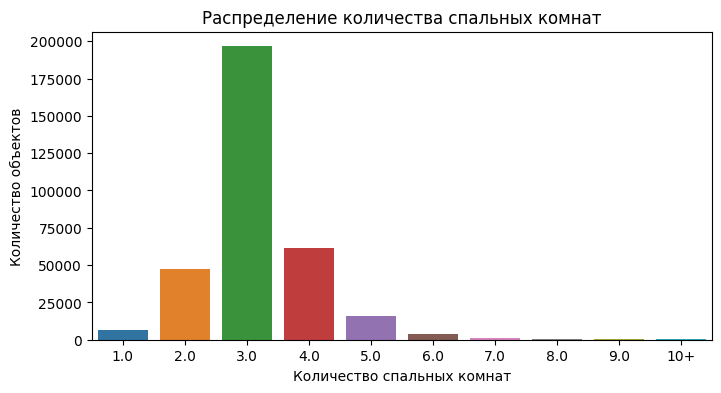

In [126]:
# Создаем категории для значений больше 10
beds_grouped = data['beds_new'].apply(lambda x: '10+' if x >= 10 else str(x))

# Укажим желаемый порядок категорий
desired_order = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10+']

# Подсчитаем количество объектов в каждой категории и отсортируйте их
beds_counts = beds_grouped.value_counts().loc[desired_order]

# Визуализация
plt.figure(figsize=(8, 4))
sns.barplot(x=beds_counts.index, y=beds_counts.values)
plt.title('Распределение количества спальных комнат')
plt.xlabel('Количество спальных комнат')
plt.ylabel('Количество объектов')
plt.show()

На графике видно, что большинство объектов недвижимости имеет 3 спальни

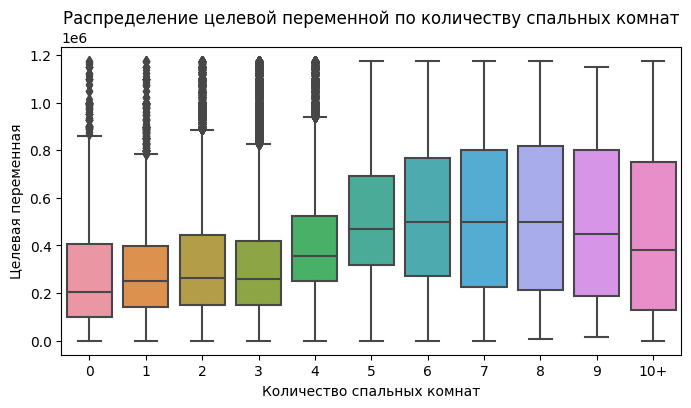

In [127]:
# Группировка значений больше 10
beds_grouped = data['beds_new'].apply(lambda x: '10+' if x >= 10 else str(int(x)))

# Указываем желаемый порядок категорий от 0 до 10 и 10+
desired_order = [str(i) for i in range(10)] + ['10+']

# Визуализация boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=beds_grouped, y=data['target'], order=desired_order)
plt.title('Распределение целевой переменной по количеству спальных комнат')
plt.xlabel('Количество спальных комнат')
plt.ylabel('Целевая переменная')
plt.show()

На основе предоставленной ящичковой диаграммы можно сделать несколько выводов:

1. **Распределение цен**: Цены на объекты с разным количеством спальных комнат имеют перекрывающиеся диапазоны, что указывает на отсутствие чёткой зависимости цены от количества спальных комнат. То есть цена может сильно варьироваться внутри каждой категории количества спален.
2. **Медианные значения**: Медианные значения (горизонтальные линии внутри каждого ящика) кажутся схожими для различных категорий, особенно начиная с 3 спален и выше, что может указывать на то, что медианная цена не сильно отличается между объектами с большим количеством спален.
3. **Разброс цен**: Межквартильные размахи (высота ящиков) и усы ящиков также показывают разброс цен в каждой категории. В некоторых категориях, таких как 0 и 10+, разброс цен кажется больше, чем в других, что может указывать на большее разнообразие объектов в этих категориях.

### stories

В этом коде происходит очистка и стандартизация данных в столбце 'stories', который содержит информацию о количестве этажей в объектах недвижимости. Используются регулярные выражения для преобразования словесных обозначений чисел (например, "One", "Two") в соответствующие числовые значения. После применения этих паттернов любые оставшиеся нечисловые символы удаляются, и данные преобразуются в числовой формат. Пустые строки заменяются на значения NaN, которые затем удаляются. Наконец, пропущенные значения в 'stories' заполняются медианным значением этого столбца, что позволяет стандартизировать данные для дальнейшего анализа или моделирования.

In [128]:
# Паттерны для оптимизации
patterns = {
    r"(?i)\b(One)\b": "1",
    r"(?i)\b(Two)\b": "2",
    r"(?i)\b(Three)\b": "3",
    r"(?i)\b(Four)\b": "4",
    r"(?i)\b(Five)\b": "5",
    r"(?i)\b(.0)\b": "",
}

# Оптимизация столбца 'stories' с помощью паттернов
data['stories'] = data['stories'].replace(patterns, regex=True)

# Извлечем только цифры и преобразуем в числа
data['stories'] = data['stories'].apply(lambda x: re.sub(r'\D', '', str(x)))
data['stories'] = data['stories'].replace('', np.nan)
data['stories'] = data['stories'].dropna().astype(int)

# Замена пустых значений 'stories' на медианное значение этого столбца
data['stories'].fillna(data['stories'].median(), inplace=True)

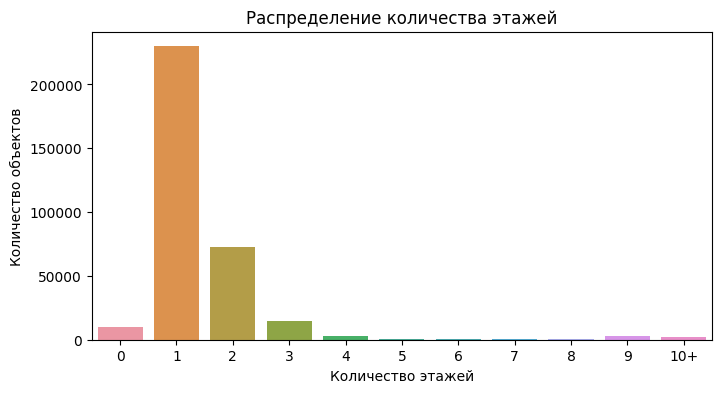

In [129]:
# Группировка значений больше 20
stories_grouped = data['stories'].apply(lambda x: '10+' if x >= 10 else str(int(x)))

# Указываем желаемый порядок категорий от 0 до 10 и 10+
desired_order = [str(i) for i in range(10)] + ['10+']

# Подсчитываем количество объектов в каждой категории с учетом заданного порядка
stories_counts = stories_grouped.value_counts().reindex(desired_order)

# Визуализация
plt.figure(figsize=(8, 4))
sns.barplot(x=stories_counts.index, y=stories_counts.values)
plt.title('Распределение количества этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Количество объектов')
plt.show()

На графике видно, что в основном домовледения распределены от 0 до 4 этажей, наибольшее количество одноэтажние.

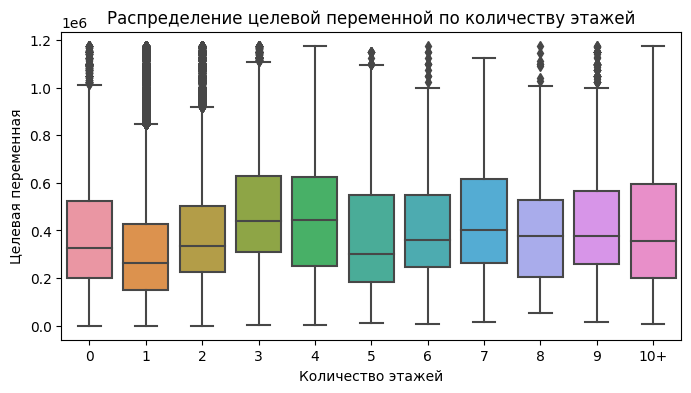

In [130]:
# Группировка значений больше 10
stories_grouped = data['stories'].apply(lambda x: '10+' if x > 10 else str(int(x)))

# Указываем желаемый порядок категорий от 0 до 10 и 10+
desired_order = [str(i) for i in range(10)] + ['10+']

# Визуализация boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=stories_grouped, y=data['target'], order=desired_order)
plt.title('Распределение целевой переменной по количеству этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Целевая переменная')
plt.show()

На основе представленного графика, ящичковой диаграммы распределения целевой переменной по количеству этажей, можно сделать вывод:
Медиана (центральная линия внутри каждого ящика) изменяется незначительно с увеличением количества этажей. Распределение значений целевой переменной также кажется схожим по ширине межквартильного размаха (разница между верхней и нижней границей ящика) для разных категорий этажности, что может указывать на стабильность разброса цен вне зависимости от количества этажей.

### mls-id

In [131]:
# Объединение двух признаков с учетом пустых значений
data['mlsID'] = data['MlsId'].fillna(data['mls-id'])
# Удалим вспомогательные столбцы
data = data.drop(['MlsId', 'mls-id'], axis=1)

# Находим моду признака "mlsID"
mode_mlsID = data['mlsID'].mode()[0]

# Замена пустых значений на моду
data['mlsID'].fillna(mode_mlsID, inplace=True)

### Private_Pool

В этом коде создается единый признак 'Private_Pool', обобщающий информацию о наличии частного бассейна из двух разных столбцов 'PrivatePool' и 'private pool'. Сначала с помощью лямбда-функции значения в этих столбцах преобразуются в бинарный формат, где '1' означает отсутствие бассейна, а '0' — его наличие. Затем эти столбцы объединяются в один, где '1' приоритетно выбирается в случае различий. После объединения изначальные столбцы удаляются, и итоговый столбец 'Private_Pool' конвертируется в целочисленный формат для дальнейшего анализа или моделирования.

In [132]:
# Создадим словарь для замены значений, где 1 - отстутствует, 0-присутствует
replace_func = lambda x: '1' if x in ['Yes', 'yes'] else '0'

# применим lambda функцию
data['PrivatePool'] = data['PrivatePool'].map(replace_func)
data['private pool'] = data['private pool'].map(replace_func)

# Объединим значения из двух признаков в один
data['Private_Pool'] = np.where(data['PrivatePool'] == '1', data['PrivatePool'], data['private pool'])

# Удалим лишние столбцы
data = data.drop(['PrivatePool', 'private pool'], axis=1)

data['Private_Pool'] = data['Private_Pool'].astype(int)

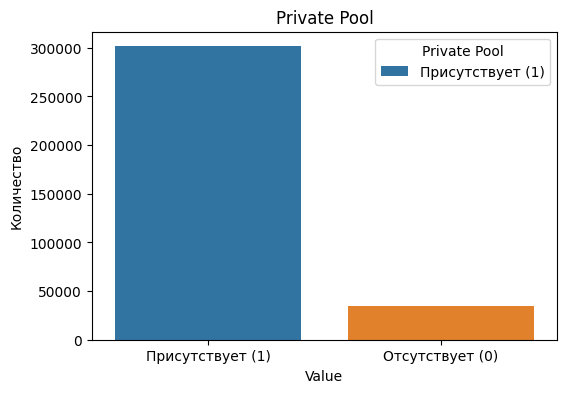

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем график для признака Private_Pool
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Private_Pool')
plt.title('Private Pool')
plt.xlabel('Value')
plt.ylabel('Количество')

# Заменяем подписи оси x
plt.xticks([0, 1], ['Присутствует (1)', 'Отсутствует (0)'])

# Добавляем легенду
plt.legend(title='Private Pool', labels=['Присутствует (1)', 'Отсутствует (0)'])
plt.show()

На графике видно, что у большинства домовладений пристутствует частный бассейн

### YearBuilt

В этом коде для столбца 'YearBuilt', содержащего год постройки объектов недвижимости, сначала заполняются пустые значения медианным годом постройки, затем все данные преобразуются в числовой формат, причем нечисловые значения заменяются на `NaN`. После этого NaN-значения снова заполняются медианным значением, и весь столбец приводится к целочисленному типу, чтобы обеспечить единообразие и точность данных для анализа.

In [134]:
# Замена пустых значений в столбце 'YearBuilt' на медианное значение этого столбца
data['YearBuilt'].fillna(data['YearBuilt'].median(), inplace=True)

data['YearBuilt'] = data['YearBuilt'].astype(int)

# Преобразование пустых строк и других нечисловых значений в NaN
data['YearBuilt'] = pd.to_numeric(data['YearBuilt'], errors='coerce')

# Заполнение NaN медианой
data['YearBuilt'].fillna(data['YearBuilt'].median(), inplace=True)

# Преобразование данных в целочисленный тип
data['YearBuilt'] = data['YearBuilt'].astype(int)

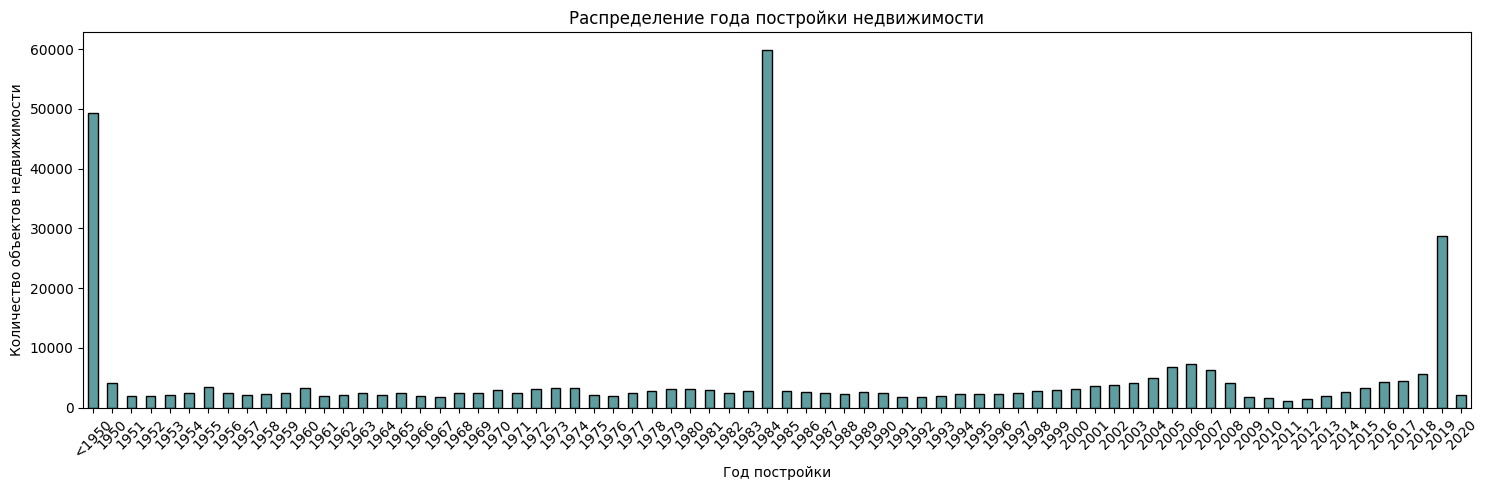

In [135]:
# Группировка данных: все до 1950 группируем в одну категорию
YearBuiltGrouped = data['YearBuilt'].apply(lambda x: '<1950' if x < 1950 else str(x))

# Получаем уникальные значения в правильном порядке
unique_years = ['<1950'] + [str(year) for year in range(1950, 2021)]
year_order = {year: order for order, year in enumerate(unique_years)}

# Сортируем годы постройки в соответствии с порядком, установленным выше
ordered_year_counts = YearBuiltGrouped.value_counts().reindex(unique_years, fill_value=0)

# Гистограмма распределения группированных годов постройки
plt.figure(figsize=(15, 5))
ordered_year_counts.plot(kind='bar', color='cadetblue', edgecolor='black')

# Настройки графика
plt.title('Распределение года постройки недвижимости')
plt.xlabel('Год постройки')
plt.ylabel('Количество объектов недвижимости')
plt.xticks(rotation=45)  # Поворот подписей на оси X для лучшей читаемости
plt.tight_layout()
plt.show()


Представленный график иллюстрирует распределение объектов недвижимости по году их постройки. На графике видно, что большинство объектов были построены в два периода: до 1950 года и после 2010 года. Между этими периодами количество построенных объектов недвижимости значительно меньше. Такое распределение может отражать исторические тренды в строительстве и экономические циклы, например, периоды повышенного строительства могут совпадать с экономическими бумами или программами стимулирования строительной отрасли. Отметим, что на графике данные до 1950 года сгруппированы в одну колонку, что может указывать на то, что статистика за более ранний период либо несущественна, либо отсутствует.

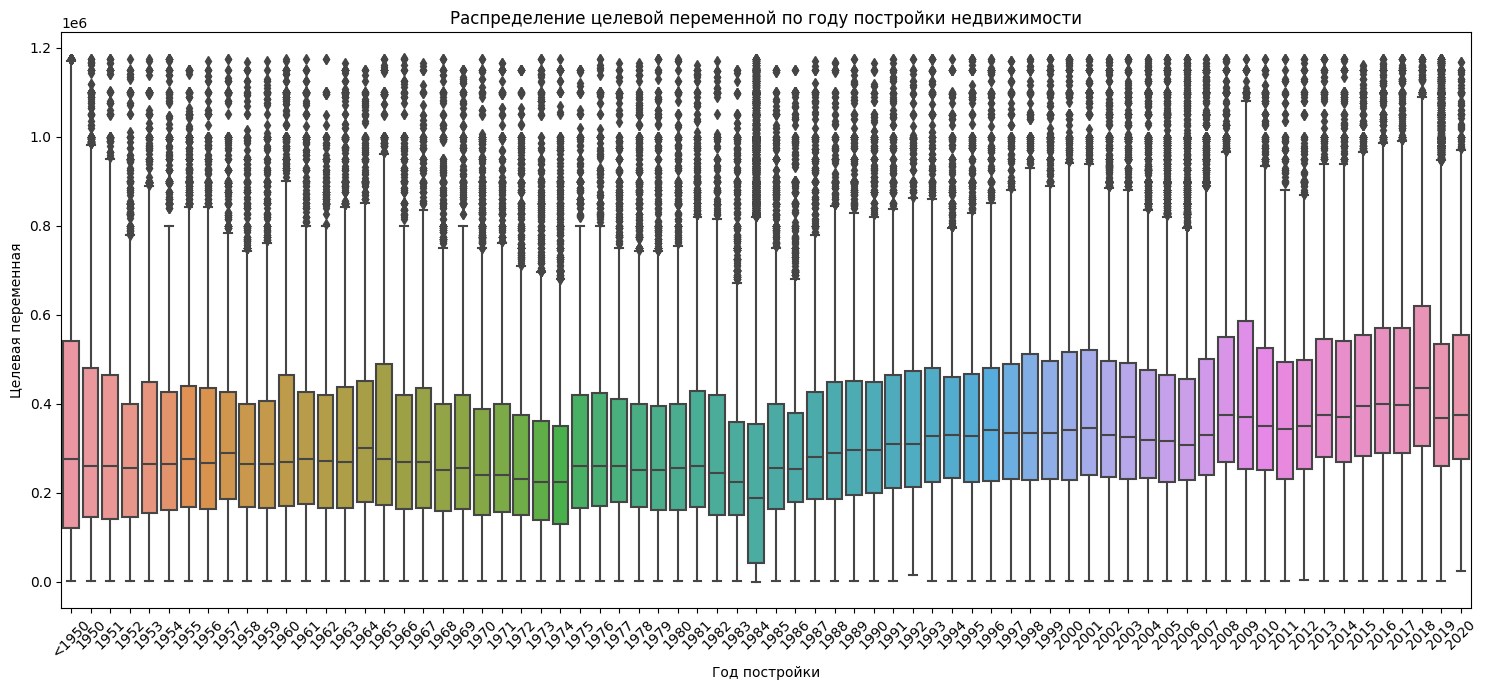

In [136]:
# Группировка данных: все до 1950 группируем в одну категорию
YearBuiltGrouped = data['YearBuilt'].apply(lambda x: '<1950' if x < 1950 else str(x))

# Получаем уникальные значения в правильном порядке
unique_years = ['<1950'] + [str(year) for year in range(1950, 2021)]

# Построение коробчатого графика
plt.figure(figsize=(15, 7))
sns.boxplot(x=YearBuiltGrouped, y=data['target'], order=unique_years)
plt.title('Распределение целевой переменной по году постройки недвижимости')
plt.xlabel('Год постройки')
plt.ylabel('Целевая переменная')
plt.xticks(rotation=45)  # Поворот подписей на оси X для лучшей читаемости
plt.tight_layout()
plt.show()


На основе представленной ящичковой диаграммы можно сделать следующие выводы:

1. **Однородность цен**: Медианы цен (центральные линии в ящиках) демонстрируют относительную однородность через различные периоды постройки. Это может свидетельствовать о том, что год постройки по себе не является ключевым дифференцирующим фактором цен на недвижимость.

2. **Выбросы**: В каждой категории есть значительное количество выбросов, что указывает на значительную вариативность цен в каждом периоде. Это может быть связано с различиями в качестве, местоположении, размере и других атрибутах недвижимости, которые не учитываются просто годом постройки.

3. **Разброс цен**: Межквартильные размахи (размеры ящиков) варьируются от периода к периоду, что может отражать различные рыночные условия в разное время, например, изменения в экономике или в спросе на недвижимость.

4. **Современная недвижимость**: Недвижимость, построенная в более поздние периоды (конец графика), кажется имеет более высокую медиану цен, особенно после 2000 года, что может отражать современные тренды в строительстве или повышение стоимости недвижимости.

5. **Историческая недвижимость**: Первая категория "<1950" показывает более широкий межквартильный размах и большое количество выбросов, что может указывать на большой разброс цен в исторической недвижимости, возможно, из-за разнообразия состояния сохранности и местоположения.

В целом, для более глубокого понимания динамики рынка недвижимости необходимо рассмотреть дополнительные данные и провести более детальный анализ, учитывая другие важные факторы, такие как местоположение, размер, состояние и удобства недвижимости.

### RemodeledYear

В этом коде обрабатывается столбец 'RemodeledYear', который указывает на год ремонта недвижимости. Сначала пустые строки заменяются на `NaN`, чтобы стандартизировать пропущенные значения. Затем заменим пустые на ноль. Это обеспечивает заполнение отсутствующих или неопределенных данных типичными значениями для данного признака. В конце все данные приводятся к целочисленному типу, что упрощает анализ и моделирование.

In [137]:
# Преобразование пустых строк в NaN
data['RemodeledYear'] = data['RemodeledYear'].replace('', np.nan)

'''# Вычисление медианы признака "RemodeledYear"
median_remodeled_year = data['RemodeledYear'].median()

# Замена нулей и пропусков на медиану
data['RemodeledYear'] = data['RemodeledYear'].replace(0, median_remodeled_year)'''

data['RemodeledYear'].fillna(0, inplace=True) # median_remodeled_year

data['RemodeledYear'] = data['RemodeledYear'].astype(int)

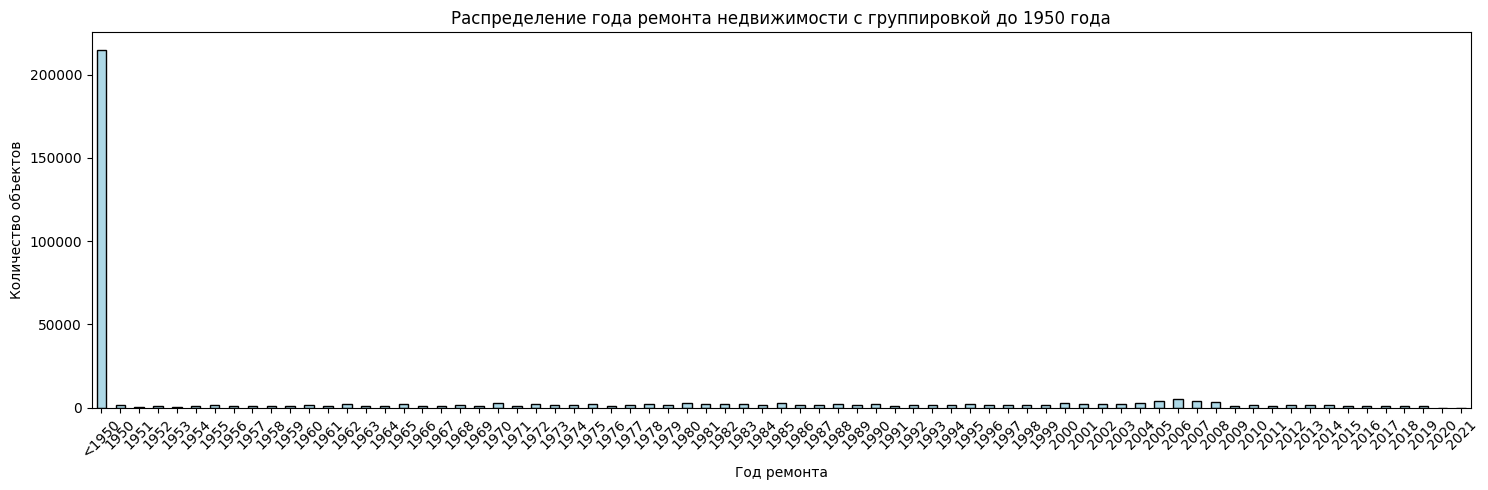

In [138]:
# Группировка значений до 1950 года в одну категорию
YearCategory = data['RemodeledYear'].apply(lambda x: '<1950' if x < 1950 else str(x))

# Получение упорядоченных уникальных значений
ordered_years = ['<1950'] + [str(year) for year in range(1950, data['RemodeledYear'].max() + 1)]

# Подсчет количества для каждой категории с учетом порядка
grouped_values = YearCategory.value_counts().reindex(ordered_years, fill_value=0)

# Отображение гистограммы с группировкой
plt.figure(figsize=(15, 5))
grouped_values.plot(kind='bar', color='lightblue', edgecolor='black')

# Настройка графика
plt.title('Распределение года ремонта недвижимости с группировкой до 1950 года')
plt.xlabel('Год ремонта')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)  # Поворот подписей для лучшей читаемости
plt.tight_layout()
plt.show()


На графике видно, что основные значения находятся до 1950 года, остальные данные распределены равномерно.

### LotSize

В данном коде обрабатывается столбец 'LotSize', который отображает размер участка недвижимости. Изначально все значения преобразуются в строковый формат, а затем удаляются любые запятые и пробелы для стандартизации данных. После этого производится конвертация в числовой формат (тип `float`), при этом любые неудачные преобразования заменяются на `NaN`. Далее вычисляется медианное значение 'LotSize', которое используется для замены всех пропущенных значений, обеспечивая тем самым заполнение отсутствующих данных характерным для выборки значением. Этот подход позволяет обеспечить точность и согласованность данных для дальнейшего анализа.

In [139]:
# Преобразование в строковый тип
data['LotSize'] = data['LotSize'].astype(str)

# Удаление запятых и пробелов
data['LotSize'] = data['LotSize'].str.replace(',', '').str.replace(' ', '')

# Преобразование в числовой тип (float)
data['LotSize'] = pd.to_numeric(data['LotSize'], errors='coerce')

# Находим медиану признака "LotSize"
median_LotSize = data['LotSize'].median()
# Замена пустых значений на моду
data['LotSize'].fillna(median_LotSize, inplace=True)

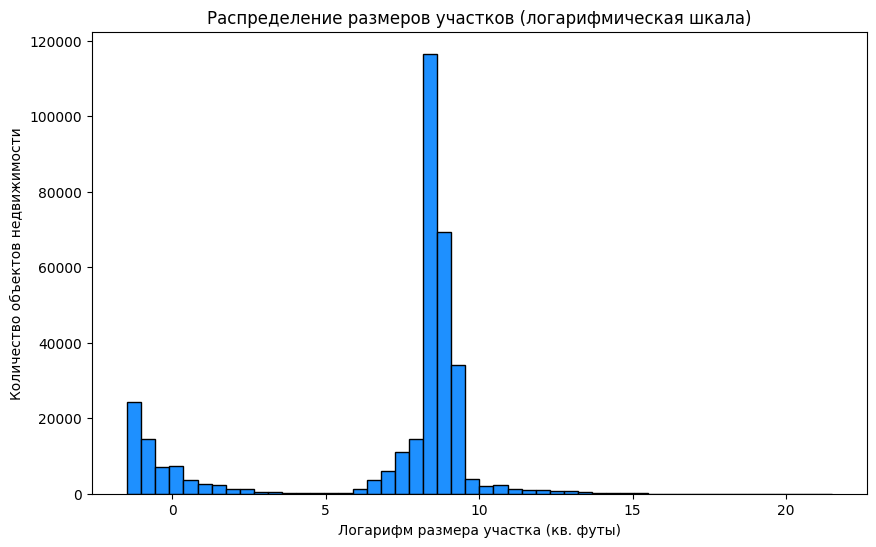

In [140]:
# Чтобы избежать искажения распределения из-за очень больших или маленьких значений,
# мы можем применить логарифмическое преобразование к значениям 'LotSize'

# Удаляем нулевые и отрицательные значения, так как логарифм от них не берется
positive_lot_sizes = data['LotSize'][data['LotSize'] > 0]

# Применяем логарифмическое преобразование
log_lot_sizes = np.log(positive_lot_sizes)

# Строим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(log_lot_sizes, bins=50, color='dodgerblue', edgecolor='black')

# Настраиваем отображение графика
plt.title('Распределение размеров участков (логарифмическая шкала)')
plt.xlabel('Логарифм размера участка (кв. футы)')
plt.ylabel('Количество объектов недвижимости')
plt.show()



На предоставленном графике отображено распределение размеров участков в логарифмическом масштабе. Видно, что большинство участков имеют относительно маленький размер, так как пики распределения сосредоточены в начале оси абсцисс. Это подтверждает, что размеры участков имеют сильный правосторонний перекос, и большинство значений находятся близко к меньшему концу диапазона.

### PricePerSqft

В этом коде выполняется обработка данных в столбце 'PricePerSqft', который представляет собой стоимость недвижимости за квадратный фут. Сначала все значения преобразуются в строковый формат, затем из этих строк извлекаются числовые значения. Если числовое значение обнаружено, оно преобразуется в тип `float`, в противном случае результат устанавливается как `NaN`. Далее вычисляется мода (наиболее часто встречающееся значение) для этого столбца, и она используется для заполнения пустых значений. Если у столбца нет однозначной моды, в качестве заполнителя используется `np.nan`. Этот метод обеспечивает адекватное заполнение пропущенных данных и подготавливает их для последующего анализа.

In [141]:
# Преобразование в формат строки
data['PricePerSqft'] = data['PricePerSqft'].astype(str)
# Извлечение числовых значений
data['PricePerSqft'] = data['PricePerSqft'].apply(lambda x: re.findall(r'\d+', x))
data['PricePerSqft'] = data['PricePerSqft'].apply(lambda x: float(x[0]) if x else np.nan)

# Вычисление моды с учетом возможности нескольких модальных значений
mode_PricePerSqft = data['PricePerSqft'].mode()
if len(mode_PricePerSqft) > 0:
    mode_PricePerSqft = mode_PricePerSqft[0]
else:
    mode_PricePerSqft = np.nan  # Если нет моды, можно использовать np.nan или другое значение по умолчанию

# Замена пустых значений на моду
data['PricePerSqft'].fillna(mode_PricePerSqft, inplace=True)

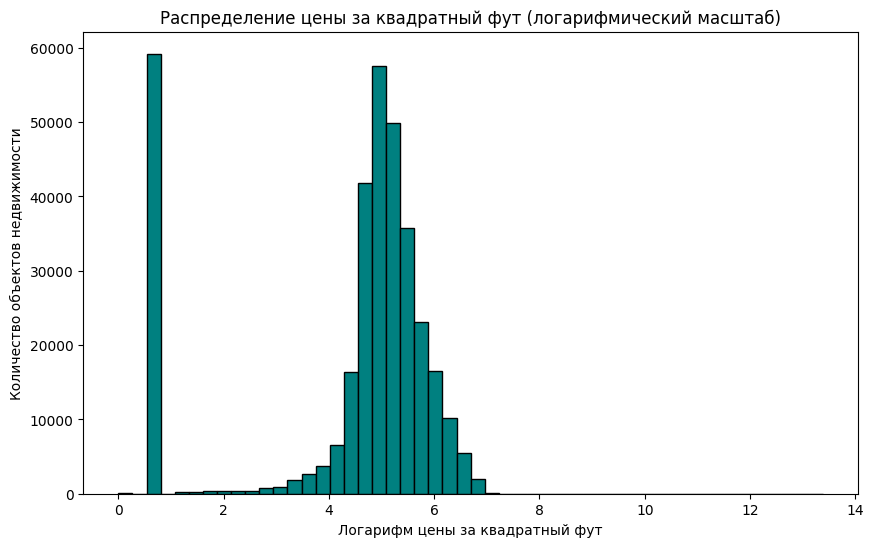

In [142]:
# Преобразование данных в логарифмический масштаб, если распределение слишком широкое
PricePerSqft_log = np.log1p(data['PricePerSqft'])

plt.figure(figsize=(10, 6))
plt.hist(PricePerSqft_log, bins=50, color='teal', edgecolor='black')
plt.title('Распределение цены за квадратный фут (логарифмический масштаб)')
plt.xlabel('Логарифм цены за квадратный фут')
plt.ylabel('Количество объектов недвижимости')
plt.show()


На гистограмме представлено распределение цен за квадратный фут в логарифмическом масштабе. Большая часть данных сгруппирована в начале оси X, что указывает на то, что большинство объектов недвижимости имеют относительно низкую стоимость за квадратный фут. Пик гистограммы находится в диапазоне низких значений логарифма цены, что может свидетельствовать о высокой концентрации объектов недвижимости с сопоставимой ценой за квадратный фут.

Распределение имеет длинный правый хвост, который тянется до более высоких значений логарифма цены, что указывает на наличие объектов с высокой стоимостью за квадратный фут, хотя их значительно меньше по сравнению с более низкими ценами.

### Avr_distance

In [143]:
# Преобразование в числовой тип (float)
data['Avr_distance'] = pd.to_numeric(data['Avr_distance'], errors='coerce')

# Вычисление медианы
median_avr_distance = data['Avr_distance'].median()

# Замена пустых значений на медиану
data['Avr_distance'].fillna(median_avr_distance, inplace=True)

In [144]:
data['Avr_distance'].describe()

count    336506.000000
mean          2.790447
std           5.722226
min           0.020000
25%           1.040000
50%           1.766667
75%           3.220000
max        1590.830000
Name: Avr_distance, dtype: float64

### MinDistance

In [145]:
# Преобразование в числовой тип (float)
data['MinDistance'] = pd.to_numeric(data['MinDistance'], errors='coerce')

# Вычисление медианы
median_MinDistance = data['MinDistance'].median()

# Замена пустых значений на медиану
data['MinDistance'].fillna(median_MinDistance, inplace=True)

### AverageRating

In [146]:
# Преобразование в числовой тип (float)
data['AverageRating'] = pd.to_numeric(data['AverageRating'], errors='coerce')

# Вычисление медианы
median_AverageRating = data['AverageRating'].median()

# Замена пустых значений на медиану
data['AverageRating'].fillna(median_AverageRating, inplace=True)

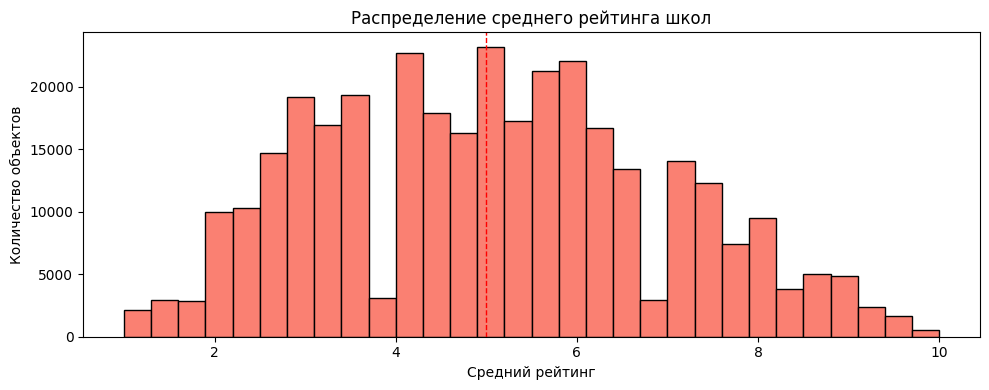

In [147]:
import matplotlib.pyplot as plt

# Настройка параметров отображения
plt.figure(figsize=(10, 4))

# Гистограмма для признака 'AverageRating'
plt.hist(data['AverageRating'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.axvline(data['AverageRating'].median(), color='red', linestyle='dashed', linewidth=1)
plt.title('Распределение среднего рейтинга школ')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество объектов')

# Показать графики
plt.tight_layout()
plt.show()

График демонстрирует распределение среднего рейтинга школ среди объектов недвижимости. Медиана, обозначенная пунктирной линией, разделяет данные на две равные части, показывая, что половина объектов имеет более высокий, а другая половина — более низкий рейтинг школ. Большинство объектов сконцентрированы вокруг средних значений рейтинга.

### Кодировка

Далее код включает в себя применение техник кодирования и преобразования категориальных данных в числовые форматы для удобства анализа и моделирования. Категориальные признаки 'city', 'street', 'state', 'status2', и 'propertyType_New' преобразуются в числовые значения с помощью LabelEncoder. Для признаков 'mlsID' и 'fireplace' применяются специфические условия: 'mlsID' кодируется наличием или отсутствием значения (1 или 0), а для 'fireplace' используется функция замены, где '1' обозначает отсутствие камина, а '0' - его наличие.

#### city

In [148]:
label_encoder = LabelEncoder()
data['city'] = label_encoder.fit_transform(data['city'])

data['city'].head()

0    1643
1    1653
4    1291
5    1332
6    1283
Name: city, dtype: int64

#### MlsId

In [149]:
# Заменяем все непустые значения на 1, остальные на 1
data['mlsID'] = data['mlsID'].apply(lambda x: 1 if pd.notnull(x) else 0)

#### fireplace

In [150]:
# Создадим словарь для замены значений, где 1 - отстутствует, 0-присутствует
replace_func = lambda x: '1' if x in ['', 'No', 'No Fireplace', 'None', 'Not Applicable'] else '0'

# применим lambda функцию
data['fireplace'] = data['fireplace'].map(replace_func).astype(float)
data['fireplace'] = data['fireplace'].astype(int)

data['fireplace'].value_counts()

0    334224
1      2282
Name: fireplace, dtype: int64

#### street, state, status2, propertyType_New

In [151]:
label_encoder = LabelEncoder()
data['street'] = label_encoder.fit_transform(data['street'])
data['state'] = label_encoder.fit_transform(data['state'])
data['status2'] = label_encoder.fit_transform(data['status2'])
data['propertyType_New'] = label_encoder.fit_transform(data['propertyType_New'])

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336506 entries, 0 to 377184
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   street            336506 non-null  int64  
 1   baths             336506 non-null  int64  
 2   fireplace         336506 non-null  int64  
 3   city              336506 non-null  int64  
 4   sqft              336506 non-null  float64
 5   zipcode           336506 non-null  int64  
 6   state             336506 non-null  int64  
 7   stories           336506 non-null  float64
 8   target            336506 non-null  float64
 9   status2           336506 non-null  int64  
 10  propertyType_New  336506 non-null  int64  
 11  state_full        336506 non-null  object 
 12  YearBuilt         336506 non-null  int64  
 13  RemodeledYear     336506 non-null  int64  
 14  Heating           336506 non-null  int64  
 15  Cooling           336506 non-null  int64  
 16  Parking           33

## 4.Создание модели

#### Подготовка данных

Начинем с анализа корреляции признаков в данных и создания тепловой карты для визуализации корреляционной матрицы. После вычисления корреляции признаков относительно целевой переменной 'target', проводится отбор признаков с высокой корреляцией (более 0.7). Затем визуализируется тепловая карта корреляций для всех признаков, чтобы облегчить анализ взаимосвязей. Признак 'Avr_distance' удаляется из-за его слабой корреляции или избыточности. Далее, целевой признак 'target' логарифмируется для линейной регрессии, а исходные признаки стандартизируются и разделяются на обучающую и тестовую выборки для последующего моделирования.

In [153]:
#data = pd.read_csv("data_temp2.csv")
corr = data.corr()     #построим корреляционную матрицу

new_corr = corr['target'].reset_index()
sort_corr = new_corr.sort_values('target', ascending=False)
sort_corr.head(10)

correlation_matrix = data.corr()

high_correlation = correlation_matrix[abs(correlation_matrix) > 0.7].stack().reset_index()
high_correlation = high_correlation[high_correlation['level_0'] != high_correlation['level_1']]
print(high_correlation)

/var/folders/88/7g79gm9d45d4lvwr8s3qk3jm0000gn/T/ipykernel_9579/2383274508.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/88/7g79gm9d45d4lvwr8s3qk3jm0000gn/T/ipykernel_9579/2383274508.py:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



         level_0       level_1         0
20  Avr_distance   MinDistance  0.908224
21   MinDistance  Avr_distance  0.908224


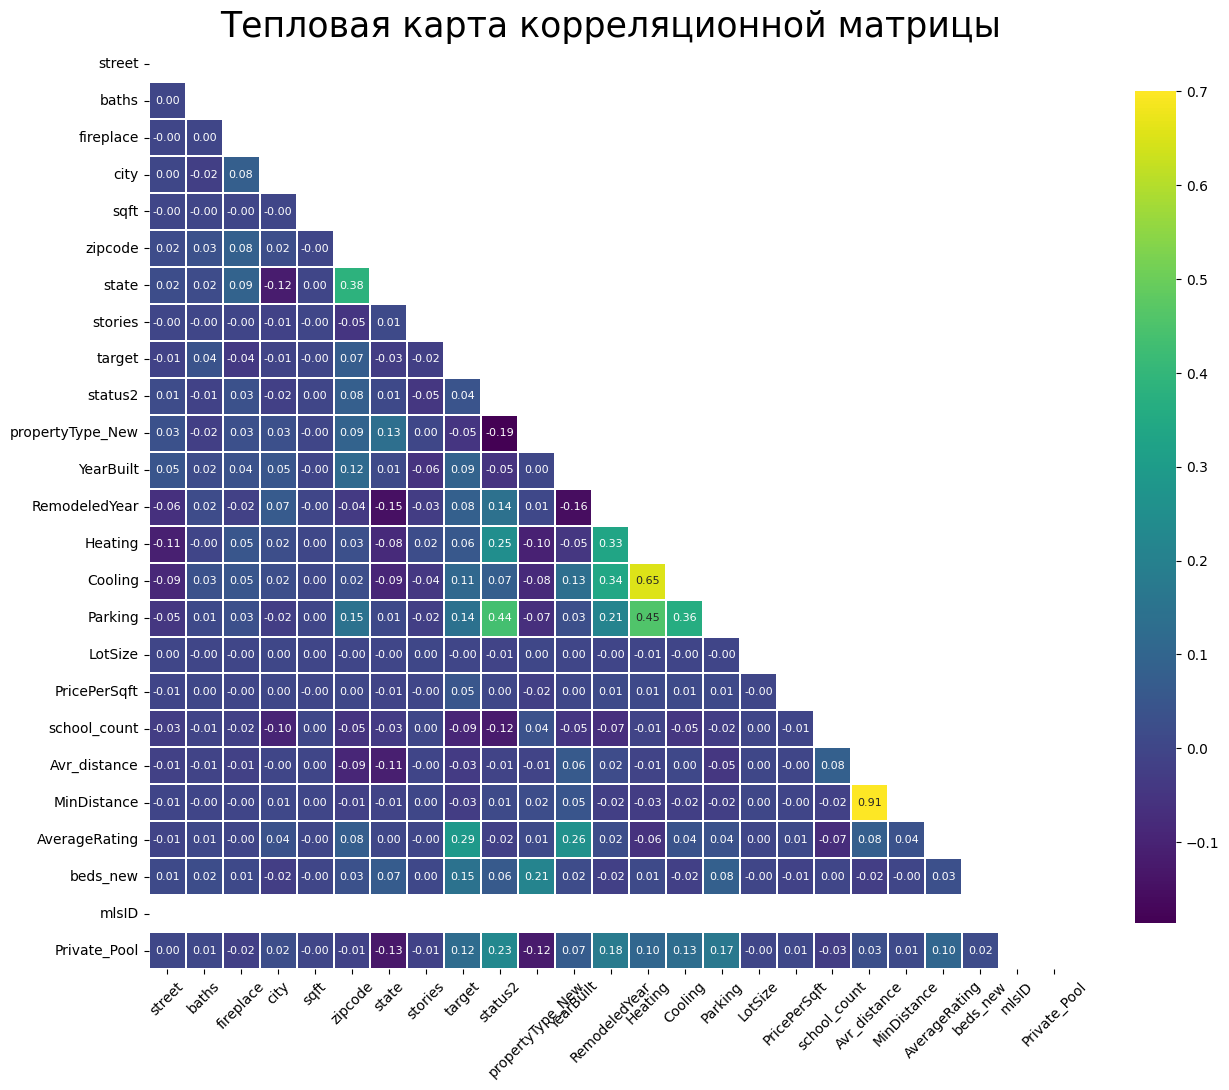

In [ ]:
# Создаем маску для отображения только нижней половины матрицы
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Создание тепловой карты с указанными размерами фигуры
plt.figure(figsize=(10, 10))

# Создадим тепловую карту с маской и указанными стилями
ax = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.25, vmax=0.7,
                 mask=mask, square=True, cbar_kws={"shrink": .9}, annot_kws={"size":8})

# Установим заголовок с размером шрифта 25
plt.title('Тепловая карта корреляционной матрицы', fontsize=25)

# Получаем текущие подписи оси X и устанавливаем желаемый наклон
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation=45)

# Получаем текущие подписи оси Y и устанавливаем желаемый наклон
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, rotation=0)

# Показываем график
plt.show()

Из представленной тепловой карты корреляционной матрицы можно сделать следующие выводы:

1. **Высокая корреляция между отоплением и охлаждением**: Наблюдается сильная положительная корреляция между системами отопления и охлаждения (0.65), что может указывать на то, что объекты, оборудованные современными системами отопления, часто также оснащены и современными системами охлаждения.

2. **Модернизация и год постройки**: Есть умеренная отрицательная корреляция между годом ремонта (RemodeledYear) и годом постройки (YearBuilt) (-0.06), что может свидетельствовать о том, что более старые дома чаще подвергаются ремонту или модернизации.

3. **Цена и минимальная дистанция до удобств**: Сильная положительная корреляция (0.91) между целевой переменной и признаком MinDistance может означать, что чем ближе недвижимость расположена к определенным удобствам или сервисам, тем выше ее цена.

4. **Значения около нуля**: Многие признаки имеют корреляцию около нуля с целевой переменной, что говорит о том, что они не имеют значительного линейного взаимодействия с ценой недвижимости.

In [72]:
# удалим лишний признак с высокой корреляцией и ранее созданный 'state_full'
data = data.drop(['Avr_distance', 'state_full'], axis=1)

data['target_log'] = np.log(data['target']+1)

X = data.drop(['target', 'Cooling','Parking', 'target_log'], axis=1)
y = data['target_log']

scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Тестирование моделей

Выполним обучение и оценку шести различных регрессионных моделей:

In [328]:
# 1. Regression Linier
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)

In [329]:
# 2. Ridge Regression
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

In [330]:
# 3. Lasso Regression
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

In [331]:
# 4. Decision Tree Regression
decision_tree_reg = DecisionTreeRegressor()
decision_tree_reg.fit(X_train, y_train)
y_pred_tree = decision_tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)

In [332]:
# 5. Random Forest Regression
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)
y_pred_forest = random_forest_reg.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)


In [333]:
# 6. XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

Результаты оценки качества моделей (MSE и R-squared) сохраним в DataFrame results_df3, который затем отобразим для сравнения производительности различных моделей.

In [334]:
results_df3 = pd.DataFrame(index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest', 'XGBRegressor'])

results_df3['Mean Squared Error'] = [
    mse_linear,
    mse_ridge,
    mse_lasso,
    mse_tree,
    mse_forest,
    mse_xgb
]

results_df3['R-squared'] = [
    r2_score(y_test, y_pred_linear),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_lasso),
    r2_score(y_test, y_pred_tree),
    r2_score(y_test, y_pred_forest),
    r2_score(y_test, y_pred_xgb)
]

print(results_df3)

                   Mean Squared Error  R-squared
Linear Regression            0.851353   0.184500
Ridge Regression             0.851353   0.184500
Lasso Regression             1.043980  -0.000015
Decision Tree                0.163618   0.843273
Random Forest                0.088197   0.915517
XGBRegressor                 0.110783   0.893882


In [ ]:
'''                   Mean Squared Error  R-squared
Linear Regression            0.851353   0.184500
Ridge Regression             0.851353   0.184500
Lasso Regression             1.043980  -0.000015
Decision Tree                0.164901   0.842043
Random Forest                0.088654   0.915079
XGBRegressor                 0.110783   0.893882'''

Общий вывод: т.к. у нас ограниченные ресурсы, и мы ищем более быстрое обучение и предсказание, то XGBoost может быть предпочтительным выбором (справился менее чем за 1 секунду). Однако, если важнее качество предсказания и готовность жертвовать ресурсами, то Random Forest может быть предпочтительным (справился более чем за 2 минуты).

#### Построение моделей XGBoost с разными гиперпараметрами 

In [26]:
# Установка необходимого пакета, если он еще не установлен
#!pip install xgboost

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from tqdm.notebook import tqdm

# Инициализация XGBoost регрессора
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


# Определение распределений или списков возможных значений для каждого гиперпараметра
param_dist = {
    'n_estimators': randint(100, 300),  # Выбирает значение из равномерного распределения в интервале [100, 1000)
    'max_depth': randint(3, 10),  # Выбирает значение из равномерного распределения в интервале [3, 10)
    'learning_rate': uniform(0.01, 0.3),  # Выбирает значение из непрерывного распределения в интервале [0.01, 0.31)
    'colsample_bytree': uniform(0.3, 0.7),  # Выбирает значение из непрерывного распределения в интервале [0.3, 1.0)
    'subsample': uniform(0.6, 0.4)  # Выбирает значение из непрерывного распределения в интервале [0.6, 1.0)
}

# Создание объекта RandomizedSearchCV с определенными распределениями параметров
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Количество случайных комбинаций параметров для проверки
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Обучение модели с отображением прогресса и логом времени выполнения
start_time = time.time()
with tqdm(total=100) as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)
end_time = time.time()
print(f"Время выполнения обучения модели: {end_time - start_time} сек")


# Печать лучших параметров и лучшей оценки
best_params = random_search.best_estimator_.get_params()
print("Лучшие параметры:", best_params)
best_rmse = math.sqrt(-random_search.best_score_)
print(f"Лучшая RMSE на обучающем наборе данных: {best_rmse}")

# Оценка качества на тестовом наборе данных
y_pred_log = random_search.predict(X_test)
y_pred = np.exp(y_pred_log) # обратное преобразование из логарифма
y_true = np.exp(y_test)

# Расчет и вывод ошибки RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred_log))
print(f"RMSE на тестовой выборке: {rmse}")

# Расчет и вывод ошибки MSE
mse = mean_squared_error(y_test, y_pred_log)
print(f"MSE на тестовой выборке: {mse}")

# Расчет и вывод ошибки R-squared
r_squared = r2_score(y_test, y_pred_log)
print(f"R-squared на тестовой выборке: : {r_squared}")


  0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Время выполнения обучения модели: 265.4351670742035 сек
Лучшие параметры: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.865951216334456, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.14976403047360262, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 278, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9036834008396613, 'tree_method': None, 'validate_parameters': None, 'verbosi

In [ ]:
'''Время выполнения обучения модели: 265.4351670742035 сек
Лучшие параметры: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.865951216334456, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.14976403047360262, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 278, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9036834008396613, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Лучшая RMSE на обучающем наборе данных: 0.3158566611831306
RMSE на тестовой выборке: 0.3091772878906199
MSE на тестовой выборке: 0.09559059534739925
R-squared на тестовой выборке: : 0.9087304623735859'''

In [27]:
#!pip install xgboost

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from tqdm.notebook import tqdm

# Инициализация XGBoost регрессора
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


# Определение распределений или списков возможных значений для каждого гиперпараметра
param_dist = {
    'n_estimators': randint(100, 300),  # Выбирает значение из равномерного распределения в интервале [100, 1000)
    'max_depth': randint(3, 10),  # Выбирает значение из равномерного распределения в интервале [3, 10)
    'learning_rate': uniform(0.01, 0.3),  # Выбирает значение из непрерывного распределения в интервале [0.01, 0.31)
    'colsample_bytree': uniform(0.3, 0.7),  # Выбирает значение из непрерывного распределения в интервале [0.3, 1.0)
    'subsample': uniform(0.6, 0.4)  # Выбирает значение из непрерывного распределения в интервале [0.6, 1.0)
}

# Создание объекта RandomizedSearchCV с определенными распределениями параметров
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=200,  # Количество случайных комбинаций параметров для проверки
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Обучение модели с отображением прогресса и логом времени выполнения
start_time = time.time()
with tqdm(total=200) as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)
end_time = time.time()
print(f"Время выполнения обучения модели: {end_time - start_time} сек")


# Печать лучших параметров и лучшей оценки
best_params = random_search.best_estimator_.get_params()
print("Лучшие параметры:", best_params)
best_rmse = math.sqrt(-random_search.best_score_)
print(f"Лучшая RMSE на обучающем наборе данных: {best_rmse}")

# Оценка качества на тестовом наборе данных
y_pred_log = random_search.predict(X_test)
y_pred = np.exp(y_pred_log) # обратное преобразование из логарифма
y_true = np.exp(y_test)

# Расчет и вывод ошибки RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred_log))
print(f"RMSE на тестовой выборке: {rmse}")

# Расчет и вывод ошибки MSE
mse = mean_squared_error(y_test, y_pred_log)
print(f"MSE на тестовой выборке: {mse}")

# Расчет и вывод ошибки R-squared
r_squared = r2_score(y_test, y_pred_log)
print(f"R-squared на тестовой выборке: : {r_squared}")


  0%|          | 0/200 [00:00<?, ?it/s]

Время выполнения обучения модели: 516.2873840332031 сек
Лучшие параметры: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9889654159707109, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1805006133267593, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 194, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9020035519124239, 'tree_method': None, 'validate_parameters': None, 'verbosi

In [ ]:
'''Время выполнения обучения модели: 516.2873840332031 сек
Лучшие параметры: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9889654159707109, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1805006133267593, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 194, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9020035519124239, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Лучшая RMSE на обучающем наборе данных: 0.31788466073124977
RMSE на тестовой выборке: 0.31267563431085194
MSE на тестовой выборке: 0.0977660522916936
R-squared на тестовой выборке: : 0.9066533443400563'''

In [28]:
#!pip install xgboost

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from tqdm.notebook import tqdm

# Инициализация XGBoost регрессора
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


# Определение распределений или списков возможных значений для каждого гиперпараметра
param_dist = {
    'n_estimators': randint(100, 300),  # Выбирает значение из равномерного распределения в интервале [100, 1000)
    'max_depth': randint(3, 10),  # Выбирает значение из равномерного распределения в интервале [3, 10)
    'learning_rate': uniform(0.01, 0.3),  # Выбирает значение из непрерывного распределения в интервале [0.01, 0.31)
    'colsample_bytree': uniform(0.3, 0.7),  # Выбирает значение из непрерывного распределения в интервале [0.3, 1.0)
    'subsample': uniform(0.6, 0.4)  # Выбирает значение из непрерывного распределения в интервале [0.6, 1.0)
}

# Создание объекта RandomizedSearchCV с определенными распределениями параметров
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=500,  # Количество случайных комбинаций параметров для проверки
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Обучение модели с отображением прогресса и логом времени выполнения
start_time = time.time()
with tqdm(total=500) as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)
end_time = time.time()
print(f"Время выполнения обучения модели: {end_time - start_time} сек")


# Печать лучших параметров и лучшей оценки
best_params = random_search.best_estimator_.get_params()
print("Лучшие параметры:", best_params)
best_rmse = math.sqrt(-random_search.best_score_)
print(f"Лучшая RMSE на обучающем наборе данных: {best_rmse}")

# Оценка качества на тестовом наборе данных
y_pred_log = random_search.predict(X_test)
y_pred = np.exp(y_pred_log) # обратное преобразование из логарифма
y_true = np.exp(y_test)

# Расчет и вывод ошибки RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred_log))
print(f"RMSE на тестовой выборке: {rmse}")

# Расчет и вывод ошибки MSE
mse = mean_squared_error(y_test, y_pred_log)
print(f"MSE на тестовой выборке: {mse}")

# Расчет и вывод ошибки R-squared
r_squared = r2_score(y_test, y_pred_log)
print(f"R-squared на тестовой выборке: : {r_squared}")


  0%|          | 0/500 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Время выполнения обучения модели: 3965.369556903839 сек
Лучшие параметры: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9697450394287852, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2512699635557013, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 182, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.965514588367313, 'tree_method': None, 'validate_parameters': None, 'verbosit

In [ ]:
# Основная модель
'''Время выполнения обучения модели: 3965.369556903839 сек
Лучшие параметры: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9697450394287852, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2512699635557013, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 182, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.965514588367313, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Лучшая RMSE на обучающем наборе данных: 0.3181895336026595
RMSE на тестовой выборке: 0.3125426708457434
MSE на тестовой выборке: 0.0976829210993907
R-squared на тестовой выборке: : 0.9067327176869451'''

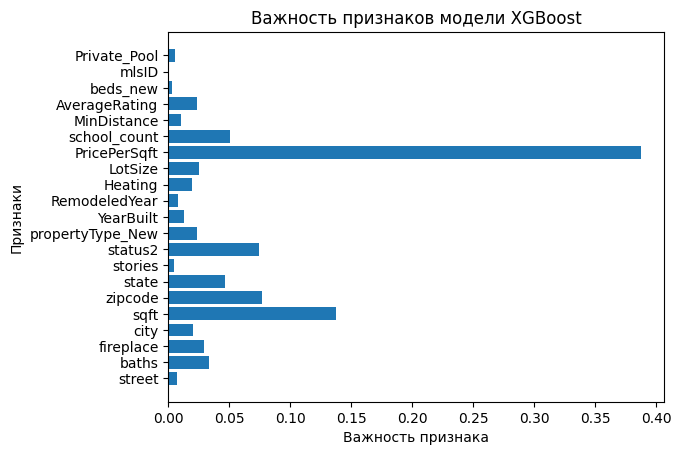

In [255]:
#model = joblib.load('model.pkl')
# Получение важности признаков
feature_importances = model.feature_importances_

# Визуализация
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), X.columns)  # X_train.columns - названия признаков
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели XGBoost')
plt.show()


На представленном графике отображается важность различных признаков для прогнозирования стоимости недвижимости с использованием модели XGBoost. Признак 'PricePerSqft', который означает цену недвижимости за квадратный фут, выделяется как наиболее значимый, что указывает на его сильное влияние на целевую переменную — цену объекта недвижимости. Признаки 'sqft' и 'zipcode' также показывают значительную важность, но они уступают 'PricePerSqft'. Это подчёркивает, что площадь объекта и местоположение при оценке стоимости, но именно соотношение цены и площади играет ключевую роль.

#### optuna

In [9]:
# Малая модель
'''import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import math'''

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0)
    }

    model = xgb.XGBRegressor(**param, objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
start_time = time.time()
study.optimize(objective, n_trials=100)  # Уменьшил количество испытаний для ускорения
end_time = time.time()

print(f"Время выполнения оптимизации: {end_time - start_time} сек")
print("Лучшие параметры:", study.best_params)

# Обучение модели с лучшими параметрами
model = xgb.XGBRegressor(**study.best_params, objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Оценка качества на тестовом наборе данных
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)  # Обратное преобразование из логарифма
y_true = np.exp(y_test)

# Расчет и вывод метрик
rmse = mean_squared_error(y_test, y_pred_log, squared=False)
print(f"RMSE на тестовой выборке: {rmse}")

mse = mean_squared_error(y_test, y_pred_log)
print(f"MSE на тестовой выборке: {mse}")

r_squared = r2_score(y_test, y_pred_log)
print(f"R-squared на тестовой выборке: {r_squared}")

[I 2024-01-04 19:19:36,063] A new study created in memory with name: no-name-08c6a6f2-ae0a-40cd-97e5-036b6474687b
[I 2024-01-04 19:19:39,338] Trial 0 finished with value: 0.3486608928117672 and parameters: {'n_estimators': 256, 'max_depth': 10, 'learning_rate': 0.02548833994527536, 'colsample_bytree': 0.48316186897888935, 'subsample': 0.8955557340774782}. Best is trial 0 with value: 0.3486608928117672.
[I 2024-01-04 19:19:40,224] Trial 1 finished with value: 0.41370629986289925 and parameters: {'n_estimators': 278, 'max_depth': 3, 'learning_rate': 0.1242976884936346, 'colsample_bytree': 0.9702737498605833, 'subsample': 0.9930415474435385}. Best is trial 0 with value: 0.3486608928117672.
[I 2024-01-04 19:19:41,293] Trial 2 finished with value: 0.3822112166288145 and parameters: {'n_estimators': 266, 'max_depth': 4, 'learning_rate': 0.19172548054961316, 'colsample_bytree': 0.4482481906716719, 'subsample': 0.6934469208618019}. Best is trial 0 with value: 0.3486608928117672.
[I 2024-01-04 

Время выполнения оптимизации: 237.79164719581604 сек
Лучшие параметры: {'n_estimators': 285, 'max_depth': 10, 'learning_rate': 0.1805685078578882, 'colsample_bytree': 0.9866608013599271, 'subsample': 0.9912944658821495}
RMSE на тестовой выборке: 0.3034086278348234
MSE на тестовой выборке: 0.09205679544461037
R-squared на тестовой выборке: 0.9121045211083355


In [5]:
# большая модель
import optuna
import xgboost as xgb
import numpy as np
import time
from sklearn.metrics import mean_squared_error, r2_score
import math

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0)
    }

    model = xgb.XGBRegressor(**param, objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
start_time = time.time()
study.optimize(objective, n_trials=100)  # Уменьшил количество испытаний для ускорения
end_time = time.time()

print(f"Время выполнения оптимизации: {end_time - start_time} сек")
print("Лучшие параметры:", study.best_params)

# Обучение модели с лучшими параметрами
model = xgb.XGBRegressor(**study.best_params, objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Оценка качества на тестовом наборе данных
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)  # Обратное преобразование из логарифма
y_true = np.exp(y_test)

# Расчет и вывод метрик
rmse = mean_squared_error(y_test, y_pred_log, squared=False)
print(f"RMSE на тестовой выборке: {rmse}")

mse = mean_squared_error(y_test, y_pred_log)
print(f"MSE на тестовой выборке: {mse}")

r_squared = r2_score(y_test, y_pred_log)
print(f"R-squared на тестовой выборке: {r_squared}")


[I 2024-01-03 16:36:17,223] A new study created in memory with name: no-name-fe0578a3-3671-44e6-ab9f-caba2970e6e2
[I 2024-01-03 16:36:36,436] Trial 0 finished with value: 0.2963163742782616 and parameters: {'n_estimators': 754, 'max_depth': 13, 'learning_rate': 0.05265912234343874, 'colsample_bytree': 0.706034621699176, 'subsample': 0.8273946836128283}. Best is trial 0 with value: 0.2963163742782616.
[I 2024-01-03 16:37:00,690] Trial 1 finished with value: 0.30198574704637154 and parameters: {'n_estimators': 1147, 'max_depth': 13, 'learning_rate': 0.14196573530674927, 'colsample_bytree': 0.8253847711082514, 'subsample': 0.926788083314567}. Best is trial 0 with value: 0.2963163742782616.
[I 2024-01-03 16:37:06,012] Trial 2 finished with value: 0.32212207790931985 and parameters: {'n_estimators': 972, 'max_depth': 6, 'learning_rate': 0.236335988838424, 'colsample_bytree': 0.38501313179725993, 'subsample': 0.7310190621160929}. Best is trial 0 with value: 0.2963163742782616.
[I 2024-01-03 

Время выполнения оптимизации: 3192.173580646515 сек
Лучшие параметры: {'n_estimators': 1272, 'max_depth': 14, 'learning_rate': 0.029523582338295894, 'colsample_bytree': 0.7713129539211835, 'subsample': 0.9766068448014599}
RMSE на тестовой выборке: 0.2924359806439912
MSE на тестовой выборке: 0.08551880277521279
R-squared на тестовой выборке: 0.9183469716943182


Общий вывод: Хотя второй подход (optuna) дает лучшую производительность модели, он значительно более времязатратен. Первый подход (RandomizedSearchCV) предлагает более быстрый процесс оптимизации с небольшим уступанием в точности. Выбор между этими двумя подходами зависит от приоритетов: если важнее точность, второй подход предпочтительнее; если важнее скорость, то первый подход может быть более подходящим. Важно отметить, что различия в производительности не так велики, что может означать, что более быстрый подход является разумным компромиссом.

## 5. Вэб-сервис

### pipeline

Создадим трансформеры для преобработки входных данных на сервер.

In [ ]:
import re
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error
import optuna
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import xgboost as xgb
import time
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

class StatusTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_status='for sale'):
        self.patterns = {
            re.compile(r' / auction|.*Auction.*', re.IGNORECASE): 'Auction',
            re.compile(r'C|Option Contract.*', re.IGNORECASE): 'Contract',
            re.compile(r'.*(Conting|Ct|CT|Coming soon|Back on Market).*'): 'Contingent',
            re.compile(r"Pf|Pre-foreclosure.*", re.IGNORECASE): 'Pre Foreclosure',
            re.compile(r"(?i)Foreclos*"): 'Foreclosure',
            re.compile(r'New.*', re.IGNORECASE): 'New',
            re.compile(r'(?i).*pending.*|P|Active Option.'): 'Pending',
            re.compile(r'(?i)For sale.*'): 'for sale',
            re.compile(r'(?i).*Sold.*'): 'Sold',
            re.compile(r'Lease/*|Apartment for rent.*', re.IGNORECASE): 'for rent',
            re.compile(r'(?i).*Backup.*|Accepted|Uc|U\sUnder\sContract|.*Under.*'): 'Under Contract',
            re.compile(r'(?i).*activ.*|Re activated.*'): 'Active'
        }
        self.mode_status = mode_status

    def fit(self, X, y=None):
        # Здесь можно вычислить и сохранить любые значения, необходимые для трансформации
        # Но в данном случае mode_status уже установлен в __init__
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Применение паттернов
        X_transformed['status2'] = X_transformed['status'].astype(str).apply(
            lambda x: next((replacement for pattern, replacement in self.patterns.items() if pattern.match(x)), x)
        )

        # Замена пустых значений на mode_status
        X_transformed['status2'].fillna(self.mode_status, inplace=True)
        X_transformed['status2'] = X_transformed['status2'].replace('nan', self.mode_status)

        # Удаляем исходный столбец 'status'
        X_transformed.drop(['status'], axis=1, inplace=True)

        return X_transformed

class StreetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_street='Address Not Disclosed'):
        self.mode_street = mode_street

    def fit(self, X, y=None):
        # В этом трансформере не требуется дополнительных вычислений при обучении,
        # так как mode_street уже установлен в __init__
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Замена пропущенных значений на mode_street
        X_transformed['street'] = X_transformed['street'].fillna(self.mode_street)

        return X_transformed

class PropertyTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.patterns = {
            r"(?i)\b(multi|condo|Condominium|Townhome|row home|co-op|coop|apartment|High Rise|Flat)\b": "multi-family",
            r"(?i)\b(Duplex|Triplex|Townhouse|townhouse|Cooperative|Penthouse|Bungalow|Multiple)\b": "multi-family",
            r"(?i)\b(Manufactured|Mfd|Mobile)\b": "Manufactured housing",
            r"(?i)\b(Single|story|Stories|transitional|Land|Ranch|Ranches|Contemporary|Colonial|Residential|Traditional|Garden Home|Cape Cod|Spanish|Mediterranean|Cluster Home|Florida|Tudor|SingleFamilyResidence|Craftsman|Cottage)\b": "one-to-four"
        }
        self.keywords = ["multi-family", "Manufactured housing", "one-to-four"]

    def transform(self, X, y=None):
        # Применение паттернов
        X['propertyType'] = X['propertyType'].replace(self.patterns, regex=True)

        # Создание нового признака
        X['propertyType_New'] = X['propertyType'].apply(
            lambda x: next((keyword for keyword in self.keywords
                            if re.search(keyword, str(x), re.IGNORECASE)), 'one-to-four')
        ).fillna('')

        # Удаление исходного столбца 'propertyType'
        X = X.drop(['propertyType'], axis=1)
        return X

    def fit(self, X, y=None):
        return self

class BathsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Извлечение только целых чисел из признака 'baths'
        X['baths'] = X['baths'].str.extract(r'(\d+)').astype(float)

        # Замена всех пустых значений на 0
        X['baths'].fillna(0, inplace=True)

        # Преобразование типа данных на целочисленный
        X['baths'] = X['baths'].astype(int)
        return X

class CityStateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Словарь для сопоставления штатов и модальных городов
        self.state_to_city = {
            'AL': 'Bryant', 'AZ': 'Glendale', 'BA': 'Unknown', 'CA': 'Los Angeles',
            'CO': 'Denver', 'DC': 'Washington', 'DE': 'Playa', 'FL': 'Miami',
            'Fl': 'Tamarac', 'GA': 'Atlanta', 'IA': 'Clear Lake', 'IL': 'Chicago',
            'IN': 'Indianapolis', 'KY': 'Hazard', 'MA': 'Boston', 'MD': 'Bethesda',
            'ME': 'Fairfield', 'MI': 'Detroit', 'MO': 'Saint Louis', 'MS': 'Cleveland',
            'MT': 'Fairfield', 'NC': 'Charlotte', 'NJ': 'Lakewood', 'NV': 'Las Vegas',
            'NY': 'Brooklyn', 'OH': 'Cleveland', 'OK': 'Cleveland', 'OR': 'Portland',
            'OS': 'Foreign Country', 'OT': 'Other', 'PA': 'Philadelphia',
            'SC': 'Fort Mill', 'TN': 'Nashville', 'TX': 'Houston', 'UT': 'Salt Lake City',
            'VA': 'Arlington', 'VT': 'Fairfax', 'WA': 'Seattle', 'WI': 'Milwaukee'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Заполняем пропущенные значения ������ородов на основе штата
        X_transformed['city'] = X_transformed.apply(
            lambda row: self.state_to_city[row['state']] if pd.isna(row['city']) else row['city'], axis=1
        )

        return X_transformed

class HomeFactsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Десериализация содержимого признака 'homeFacts'
        X['homeFacts'] = X['homeFacts'].apply(ast.literal_eval)

        # Создание новых признаков на основе десериализованных значений
        X['YearBuilt'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
        X['RemodeledYear'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
        X['Heating'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
        X['Cooling'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
        X['Parking'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
        X['LotSize'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
        X['PricePerSqft'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

        # Удаление старого столбца 'homeFacts'
        return X.drop(['homeFacts'], axis=1)

class CustomFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.values_to_replace_year_built = ['', '559990649990', 'No', '1', 'No Data']
        self.values_to_replace_heating_cooling_parking = ['', 'No Data', 'None']

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Обработка YearBuilt
        X['YearBuilt'] = np.where(X['YearBuilt'].isin(self.values_to_replace_year_built), None, X['YearBuilt'])

        # Обработка RemodeledYear
        X['RemodeledYear'] = np.where(X['RemodeledYear'] == 0, np.nan, X['RemodeledYear']).astype('object')

        # Обработка Heating, Cooling, Parking
        X['Heating'] = X['Heating'].replace(self.values_to_replace_heating_cooling_parking, 0).replace('[^0]', 1, regex=True).fillna(0).astype(int)
        X['Cooling'] = X['Cooling'].replace(self.values_to_replace_heating_cooling_parking, 0).replace('[^0]', 1, regex=True).fillna(0).astype(int)
        X['Parking'] = X['Parking'].replace(self.values_to_replace_heating_cooling_parking, 0).replace('[^0]', 1, regex=True).fillna(0).astype(int)

        # Извлечение чисел из LotSize и PricePerSqft
        X['LotSize'] = X['LotSize'].str.extract('(\d+.\d+|\d+)', expand=False)
        X['PricePerSqft'] = X['PricePerSqft'].str.extract('(\d+.\d+|\d+)', expand=False)

        return X

class SchoolsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Десериализация содержимого 'schools'
        X['schools'] = X['schools'].apply(ast.literal_eval)

        # Создание новых признаков
        X['rating'] = X['schools'].apply(lambda x: x[0]['rating'])
        X['Distance'] = X['schools'].apply(lambda x: x[0]['data']['Distance'])
        X['name_school'] = X['schools'].apply(lambda x: x[0]['name'])
        X['school_count'] = X['name_school'].apply(len)

        # Расчет суммы расстояний и средней дистанции до школ
        X['sum_distance'] = X['Distance'].apply(lambda x: sum(float(re.findall(r'\d+\.\d+', val)[0]) for val in x if re.findall(r'\d+\.\d+', val)) if x and any(re.findall(r'\d+\.\d+', val) for val in x) else None)
        X['Avr_distance'] = X['sum_distance'] / X['school_count']
        X['MinDistance'] = X['Distance'].apply(lambda x: min(float(re.findall(r'\d+\.\d+', val)[0]) for val in x if re.findall(r'\d+\.\d+', val)) if x and any(re.findall(r'\d+\.\d+', val) for val in x) else None)

        # Вычисление среднего рейтинга
        X['AverageRating'] = X['rating'].apply(self.calculate_rating)

        # Удаление вспомогательных столбцов
        return X.drop(['sum_distance', 'schools', 'rating', 'Distance', 'name_school'], axis=1)

    def calculate_rating(self, row):
        ratings = []
        for val in row:
            if re.match(r'^[\d./]+$', val):
                val = re.sub(r'/10$', '', val)
                try:
                    ratings.append(float(val))
                except ValueError:
                    pass
        return np.mean(ratings) if ratings else np.nan

class LotSizeSqftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sqft_median = 6.369  # Пример медианного значения, измените по необходимости

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Очистка и преобразование LotSize
        X['LotSize'] = X['LotSize'].str.replace(',', '.')
        X['LotSize'] = pd.to_numeric(X['LotSize'], errors='coerce')

        # Обработка sqft
        X['sqft'] = X['sqft'].apply(lambda x: re.sub(r'\D', '', str(x)))
        X['sqft'] = X['sqft'].replace('', np.nan).astype(float)
        X['sqft'].fillna(self.sqft_median, inplace=True)

        return X

class ZipcodeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.zipcode_mode = 32137  # Пример значения по умолчанию

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Применение функции для извлечения числового значения из строки индекса
        X['zipcode'] = X['zipcode'].apply(self.extract_zipcode_number)

        # Замена значений '0' и '00000' на NaN и заполнение пропущенных значений модой
        X['zipcode'].replace({'0': np.nan, '00000': np.nan}, inplace=True)
        X['zipcode'].fillna(self.zipcode_mode, inplace=True)

        # Преобразование столбца в int64
        X['zipcode'] = X['zipcode'].astype('int64')

        return X

    @staticmethod
    def extract_zipcode_number(zipcode):
        match = re.match(r'^(\d+)-?', str(zipcode))
        return match.group(1) if match else np.nan

class BedsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.median_beds_new = 3.0  # Пример значения по умолчанию

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создание условного признака для фильтрации мусорных значений
        X['temp'] = X['beds'].astype(str).str.contains(r'acre|acres|sqft', case=False, regex=True).astype(int)

        # Создание нового признака 'beds_new'
        X['beds_new'] = X.apply(lambda row: self.extract_clean_beds(row['beds'], row['temp']), axis=1)

        # Удаление вспомогательных столбцов
        X = X.drop(['beds', 'temp'], axis=1)

        # Замена пропущенных значений на медиану
        X['beds_new'] = pd.to_numeric(X['beds_new'], errors='coerce').fillna(self.median_beds_new)

        return X

    @staticmethod
    def extract_clean_beds(beds, temp):
        if temp == 0:
            nums = str(beds).split()
            for num in nums:
                if num.isdigit():
                    return num
        return np.nan

class StoriesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stories_median = 1.0  # Устанавливаем значение медианы по умолчанию

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Паттерны для преобразования строк в числа
        patterns = {
            r"(?i)\b(One)\b": "1",
            r"(?i)\b(Two)\b": "2",
            r"(?i)\b(Three)\b": "3",
            r"(?i)\b(Four)\b": "4",
            r"(?i)\b(Five)\b": "5",
            # Другие паттерны по необходимости
        }

        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Применение паттернов к столбцу 'stories'
        X_transformed['stories'] = X_transformed['stories'].replace(patterns, regex=True)

        # Извлечение только числовых значений и преобразование в числа
        X_transformed['stories'] = X_transformed['stories'].apply(lambda x: re.sub(r'\D', '', str(x)))
        X_transformed['stories'] = pd.to_numeric(X_transformed['stories'], errors='coerce')

        # Замена пустых значений на медианное значение
        X_transformed['stories'].fillna(self.stories_median, inplace=True)

        return X_transformed

class CombinedMlsIDTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_mlsID='NO MLS'):
        self.mode_mlsID = mode_mlsID

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Объединение 'MlsId' и 'mls-id' в 'mlsID'
        X_transformed = X.copy()
        X_transformed['mlsID'] = X_transformed['MlsId'].fillna(X_transformed['mls-id'])

        # Удаление исходных столбцов 'MlsId' и 'mls-id'
        X_transformed = X_transformed.drop(['MlsId', 'mls-id'], axis=1)

        # Замена пустых значений в 'mlsID' на заданный режим
        X_transformed['mlsID'].fillna(self.mode_mlsID, inplace=True)

        return X_transformed

class PoolTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Функция для преобразования значений
        replace_func = lambda x: '1' if x in ['Yes', 'yes'] else '0'

        # Применение функции к столбцам
        X['PrivatePool'] = X['PrivatePool'].map(replace_func)
        X['private pool'] = X['private pool'].map(replace_func)

        # Объединение значений в один столбец
        X['Private_Pool'] = np.where(X['PrivatePool'] == '1', X['PrivatePool'], X['private pool'])

        # Преобразование типа столбца 'Private_Pool' в int
        X['Private_Pool'] = X['Private_Pool'].astype(int)

        # Удаление исходных столбцов
        return X.drop(['PrivatePool', 'private pool'], axis=1)

'''class YearBuiltTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_year=1980):
        self.median = median_year

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Преобразование пустых строк и других нечисловых значений в NaN
        X_transformed = X.copy()
        X_transformed['YearBuilt'] = pd.to_numeric(X_transformed['YearBuilt'], errors='coerce')

        # Заполнение NaN медианным значением
        X_transformed['YearBuilt'].fillna(self.median, inplace=True)

        # Преобразование данных в целочисленный тип
        X_transformed['YearBuilt'] = X_transformed['YearBuilt'].astype(int)

        return X_transformed'''

class YearBuiltTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_year=1980):
        self.median_year = median_year

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed['YearBuilt'] = pd.to_numeric(X_transformed['YearBuilt'], errors='coerce')
        X_transformed['YearBuilt'].fillna(self.median_year, inplace=True)
        X_transformed['YearBuilt'] = X_transformed['YearBuilt'].astype(int)
        return X_transformed

'''class RemodeledYearTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_year=1985):
        self.median_year = median_year

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Преобразование пустых строк в np.nan
        X_transformed = X.copy()
        X_transformed['RemodeledYear'] = X_transformed['RemodeledYear'].replace('', np.nan)

        # Преобразование в числовой тип и замена нулей на медиану
        X_transformed['RemodeledYear'] = pd.to_numeric(X_transformed['RemodeledYear'], errors='coerce')
        X_transformed['RemodeledYear'] = X_transformed['RemodeledYear'].replace(0, self.median_year)

        # Заполнение пропущенных значений медианой
        X_transformed['RemodeledYear'].fillna(self.median_year, inplace=True)

        # Преобразование в целочисленный тип
        X_transformed['RemodeledYear'] = X_transformed['RemodeledYear'].astype(int)

        return X_transformed'''
        
class RemodeledYearTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Инициализация не требуется
        pass

    def fit(self, X, y=None):
        # Подгонка не требуется
        return self

    def transform(self, X, y=None):
        # Преобразование пустых строк и строк с нулем в np.nan
        X_transformed = X.copy()
        X_transformed['RemodeledYear'] = X_transformed['RemodeledYear'].replace('', np.nan).replace('0', np.nan)
        
        # Преобразование в числовой тип
        X_transformed['RemodeledYear'] = pd.to_numeric(X_transformed['RemodeledYear'], errors='coerce')
        
        # Замена np.nan на 0, если это предпочтительное значение для отсутствующих данных
        X_transformed['RemodeledYear'].fillna(0, inplace=True)
        
        # Преобразование в целочисленный тип
        X_transformed['RemodeledYear'] = X_transformed['RemodeledYear'].astype(int)

        return X_transformed

class LotSizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_lot_size=6.369):
        self.median_lot_size = median_lot_size

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Преобразование в строковый тип и очистка данных
        X_transformed['LotSize'] = X_transformed['LotSize'].astype(str).str.replace(',', '').str.replace(' ', '')

        # Преобразование в числовой тип и заполнение пропущенных значений медианой
        X_transformed['LotSize'] = pd.to_numeric(X_transformed['LotSize'], errors='coerce').fillna(self.median_lot_size)

        return X_transformed

class PricePerSqftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode=1.0):
        self.mode = mode

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Извлечение числовых значений из строк
        X_transformed['PricePerSqft'] = X_transformed['PricePerSqft'].astype(str).apply(lambda x: re.findall(r'\d+', x))
        X_transformed['PricePerSqft'] = X_transformed['PricePerSqft'].apply(lambda x: float(x[0]) if x else np.nan)

        # Замена пустых значений на моду
        X_transformed['PricePerSqft'].fillna(self.mode, inplace=True)
        
        return X_transformed

class AvrDistanceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_avr_distance=1.7666):
        self.median_avr_distance = median_avr_distance

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Преобразование в числовой тип и заполнение пропущенных значений медианой
        X_transformed['Avr_distance'] = pd.to_numeric(X_transformed['Avr_distance'], errors='coerce').fillna(self.median_avr_distance)
        
        return X_transformed

class MinDistanceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_min_distance=0.7):
        self.median_min_distance = median_min_distance

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для б����зоп��сного преобразования
        X_transformed = X.copy()

        # Преобразование в числовой тип и заполнение пропущенных значений медианой
        X_transformed['MinDistance'] = pd.to_numeric(X_transformed['MinDistance'], errors='coerce').fillna(self.median_min_distance)

        return X_transformed

class AverageRatingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_average_rating=5.0):
        self.median_average_rating = median_average_rating

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Преобразование значения среднего рейтинга, заполнение пустых значений медианным значением
        X_transformed['AverageRating'] = pd.to_numeric(X_transformed['AverageRating'], errors='coerce')
        X_transformed['AverageRating'].fillna(self.median_average_rating, inplace=True)

        return X_transformed

class MlsIDFireplaceTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Преобразование 'mlsID'
        X['mlsID'] = X['mlsID'].apply(lambda x: 1 if pd.notnull(x) else 0)

        # Преобразование 'fireplace'
        replace_func = lambda x: '1' if x in ['', 'No', 'No Fireplace', 'None', 'Not Applicable'] else '0'
        X['fireplace'] = X['fireplace'].map(replace_func).astype(int)

        return X

'''class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for col in ['city', 'street', 'state', 'status2', 'propertyType_New']:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self

    def transform(self, X, y=None):
        for col, encoder in self.encoders.items():
            X[col] = encoder.transform(X[col])
        return X'''

'''class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode=None):
        self.features_to_encode = features_to_encode
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.features_to_encode:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for col, encoder in self.encoders.items():
            X_transformed[col] = encoder.transform(X[col])
        return X_transformed'''

'''class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode=None):
        self.features_to_encode = features_to_encode
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.features_to_encode:
            if col in X:
                self.encoders[col] = LabelEncoder().fit(X[col].fillna('Missing'))
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for col, encoder in self.encoders.items():
            if col in X_transformed:
                X_transformed[col] = encoder.transform(X_transformed[col].fillna('Missing'))
        return X_transformed'''

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode=None):
        self.features_to_encode = features_to_encode
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.features_to_encode:
            # Если данные не категориальные, преобразуем их в строки
            if not pd.api.types.is_categorical_dtype(X[col]):
                X[col] = X[col].astype(str)
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for col, encoder in self.encoders.items():
            # Преобразование данных в строки, если они не категориальные
            if not pd.api.types.is_categorical_dtype(X[col]):
                X_transformed[col] = X[col].astype(str)
            X_transformed[col] = encoder.transform(X_transformed[col])
        return X_transformed

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.features_to_drop, axis=1, errors='ignore')

class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Обучаем StandardScaler на данных X
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        # Применяем масштабирование к данным X
        X_scaled = self.scaler.transform(X)
        return X_scaled


In [ ]:
#не сработало
'''transformers = [
    ('status_transformer', StatusTransformer(mode_status='for sale')),
    ('street_transformer', StreetTransformer()),
    ('property_type_transformer', PropertyTypeTransformer()),
    ('baths_transformer', BathsTransformer()),
    ('city_state_transformer', CityStateTransformer()),
    ('home_facts_transformer', HomeFactsTransformer()),
    ('custom_transformer', CustomFeaturesTransformer()),
    ('schools_transformer', SchoolsTransformer()),
    ('lotsize_sqft_transformer', LotSizeSqftTransformer()),
    ('zipcode_transformer', ZipcodeTransformer()),
    ('beds_transformer', BedsTransformer()),
    ('stories_transformer', StoriesTransformer()),
    ('combined_mls_id_transformer', CombinedMlsIDTransformer()),
    ('pool_transformer', PoolTransformer()),
    ('year_built_transformer', YearBuiltTransformer()),
    ('remodeled_year_transformer', RemodeledYearTransformer()),
    ('lotsize_transformer', LotSizeTransformer()),
    ('price_per_sqft_transformer', PricePerSqftTransformer()),
    ('avr_distance_transformer', AvrDistanceTransformer()),
    ('min_distance_transformer', MinDistanceTransformer()),
    ('average_rating_transformer', AverageRatingTransformer()),
    ('mls_id_fireplace_transformer', MlsIDFireplaceTransformer()),
    ('feature_dropper', FeatureDropper(features_to_drop=['Avr_distance', 'target', 'Cooling', 'Parking'])),
    #('scaler', StandardScaler())
]

# Объединение всех трансформеров в один pipeline
preprocessing_pipeline = Pipeline(steps=transformers)

# Инициализация CategoricalEncoder с указанными признаками для кодирования
categorical_features = ['city', 'street', 'state', 'status2', 'propertyType_New']
categorical_transformer = CategoricalEncoder(features_to_encode=categorical_features)

from sklearn.compose import ColumnTransformer
# Добавление CategoricalEncoder в pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Остальные признаки не изменяются
)

# Сборка полного pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('categorical', preprocessor),
    ('scaler', StandardScaler())
])'''

In [ ]:
# Обучаем StandardScaler
scaler = StandardScalerTransformer()
X_scaled = scaler.fit(X)

# Сохраним в файл обученный трансформер
with open('scaler2.pkl', 'wb') as f:
    dill.dump(scaler, f)

### Flask приложение

In [ ]:
import joblib

# Сохраним обученную модель в отдельный файл
joblib.dump(model, 'model.pkl')

In [122]:
#pip install flask

In [6]:
# Производим десериализацию и извлекаем модель из файла формата pkl
import pickle
with open('model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9866608013599271, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1805685078578882, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=285, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib
import numpy as np
import dill

# Импорт классов трансформеров
from transformers2 import (
    StatusTransformer,
    StreetTransformer,
    PropertyTypeTransformer,
    BathsTransformer,
    CityStateTransformer,
    HomeFactsTransformer,
    CustomFeaturesTransformer,
    SchoolsTransformer,
    LotSizeSqftTransformer,
    ZipcodeTransformer,
    BedsTransformer,
    StoriesTransformer,
    CombinedMlsIDTransformer,
    PoolTransformer,
    YearBuiltTransformer,
    RemodeledYearTransformer,
    LotSizeTransformer,
    PricePerSqftTransformer,
    AvrDistanceTransformer,
    MinDistanceTransformer,
    AverageRatingTransformer,
    CategoricalEncoder,
    MlsIDFireplaceTransformer,
    FeatureDropper,
    StandardScalerTransformer,
    CategoricalEncoder
)

app = Flask(__name__)

# Создание экземпляров трансформеров
transformers = [
    StatusTransformer(),
    StreetTransformer(),
    PropertyTypeTransformer(),
    BathsTransformer(),
    CityStateTransformer(),
    HomeFactsTransformer(),
    CustomFeaturesTransformer(),
    SchoolsTransformer(),
    LotSizeSqftTransformer(),
    ZipcodeTransformer(),
    BedsTransformer(),
    StoriesTransformer(),
    CombinedMlsIDTransformer(),
    PoolTransformer(),
    YearBuiltTransformer(),
    RemodeledYearTransformer(),
    LotSizeTransformer(),
    PricePerSqftTransformer(),
    AvrDistanceTransformer(),
    MinDistanceTransformer(),
    AverageRatingTransformer(),
    MlsIDFireplaceTransformer(),
    FeatureDropper(features_to_drop=['Avr_distance', 'target', 'Cooling', 'Parking'])
]

# Экземпляр CategoricalEncoder
categorical_encoder = CategoricalEncoder(features_to_encode=['city', 'street', 'state', 'status2', 'propertyType_New'])

# Загрузка экземпляра scaler
with open('scaler2.pkl', 'rb') as f:
    scaler = dill.load(f)

@app.route('/')
def index():
    return "Привет! Это мой веб-сервис для обработки данных о недвижимости."

@app.route('/upload', methods=['POST'])
def upload_file():
    uploaded_file = request.files['file']
    if uploaded_file:
        df = pd.read_csv(uploaded_file)
        # Применение трансформеров к данным через цикл
        for transformer in transformers:
            df = transformer.transform(df)
        # Применение категоризации
        categorical_encoder.fit(df)
        df = categorical_encoder.transform(df)
        # Масштабирование данных
        df = scaler.transform(df)
        # Загрузка модели и получение предсказаний
        model = joblib.load('model.pkl')
        predictions = model.predict(df)
        # Разлогарифмирование предсказаний
        predictions = np.exp(predictions)
        return jsonify({'predictions': predictions.tolist()})
    else:
        return jsonify({'error': 'Нет файла в запросе'}), 400
          
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001)

тестовый запрос

In [ ]:
import requests

def test_request():
    # URL сервера в Docker
    url = 'http://localhost:5001/upload'  # Если сервер доступен извне Docker

    # Открытие файла для чтения в бинарном режиме
    with open('/app/dattt.csv', 'rb') as file:
        files = {'file': file}
        # Отправка POST-запроса с файлом
        response = requests.post(url, files=files)

    # Вывод ответа от сервера
    print(response.text)

if __name__ == '__main__':
    test_request()
